#Importamos librerías

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import missingno
!pip install upsetplot pyjanitor==0.23.1
import upsetplot
import janitor
import scipy.stats

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

##Funciones personalizadas para valores faltantes

Fuente: https://github.com/jhonvelasque/manipulacion-de-datos-faltantes/blob/main/pandas-missing-extension-1.ipynb

In [2]:
try:
    del pd.DataFrame.missing
except AttributeError:
    pass

In [3]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", "count": "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_case", "count": "n_cases"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending = False):

        return (
            self._obj
            .pipe(
                lambda df: (
                    df[df.isna().sum().sort_values(ascending = ascending).index]
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return (
            self._obj
            .isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix("_NA")
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing
                )
            ],
            axis="columns"
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    def missing_variable_plot(self):
        df_plot = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df_plot.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df_plot.n_missing, color="black")

        plt.plot(df_plot.n_missing.values, plot_range, "o", color="black")

        plt.yticks(plot_range, df_plot.variable)

        plt.grid(axis="x")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", color="black")

        plt.grid(axis="y")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

#Lectura de datos y exploración inicial

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data/sales_predictions.csv')

In [5]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
df.rename(columns = {'Item_Identifier' : 'item_id',
                     'Item_Weight' : 'item_w',
                     'Item_Fat_Content' : 'item_fat',
                     'Item_Visibility' : 'item_visib',
                     'Item_Type' : 'item_type',
                     'Item_MRP' : 'item_mrp',
                     'Outlet_Identifier' : 'outlet_id',
                     'Outlet_Establishment_Year' : 'outlet_estab_year',
                     'Outlet_Size' : 'outlet_size',
                     'Outlet_Location_Type' : 'outlet_loc_type',
                     'Outlet_Type' : 'outlet_type',
                     'Item_Outlet_Sales' : 'item_outlet_sales'},
          inplace = True)
df.head()

,item_id,item_w,item_fat,item_visib,item_type,item_mrp,outlet_id,outlet_estab_year,outlet_size,outlet_loc_type,outlet_type,item_outlet_sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#Valores duplicados

In [8]:
df.duplicated().sum()

0

No hay duplicados.

#Valores únicos

In [9]:
from IPython.display import display
columnas = df.columns.tolist()
for i in columnas:
  y = df[i].value_counts().to_frame().reset_index().sort_values(i)
  display(y)

,item_id,count
613,DRA12,6
212,DRA24,7
62,DRA59,8
1496,DRB01,3
793,DRB13,5
...,...,...
156,NCZ30,7
1056,NCZ41,5
1134,NCZ42,5
1120,NCZ53,5


,item_w,count
324,4.555,4
305,4.590,5
232,4.610,7
361,4.615,4
275,4.635,5
...,...,...
243,21.000,6
118,21.100,17
295,21.200,5
105,21.250,24


,item_fat,count
2,LF,316
0,Low Fat,5089
1,Regular,2889
4,low fat,112
3,reg,117


,item_visib,count
0,0.000000,526
2328,0.003575,1
6874,0.003589,1
2344,0.003598,1
1423,0.003599,1
...,...,...
7855,0.309390,1
3512,0.311090,1
4940,0.321115,1
6730,0.325781,1


,item_type,count
6,Baking Goods,648
10,Breads,251
14,Breakfast,110
5,Canned,649
4,Dairy,682
3,Frozen Foods,856
0,Fruits and Vegetables,1232
11,Hard Drinks,214
7,Health and Hygiene,520
2,Household,910


,item_mrp,count
4567,31.2900,1
3548,31.4900,1
4067,31.8900,1
1144,31.9558,2
2067,32.0558,1
...,...,...
1151,266.1884,2
2401,266.2884,1
1524,266.5884,2
1412,266.6884,2


,outlet_id,count
8,OUT010,555
1,OUT013,932
7,OUT017,926
6,OUT018,928
9,OUT019,528
0,OUT027,935
4,OUT035,930
5,OUT045,929
3,OUT046,930
2,OUT049,930


,outlet_estab_year,count
0,1985,1463
1,1987,932
3,1997,930
8,1998,555
2,1999,930
5,2002,929
4,2004,930
7,2007,926
6,2009,928


,outlet_size,count
2,High,932
0,Medium,2793
1,Small,2388


,outlet_loc_type,count
2,Tier 1,2388
1,Tier 2,2785
0,Tier 3,3350


,outlet_type,count
1,Grocery Store,1083
0,Supermarket Type1,5577
3,Supermarket Type2,928
2,Supermarket Type3,935


,item_outlet_sales,count
1766,33.2900,2
3063,33.9558,1
2702,34.6216,1
2324,35.2874,1
1363,36.6190,2
...,...,...
2496,10306.5840,1
3189,10993.6896,1
2848,11445.1020,1
2132,12117.5600,1


In [10]:
df['item_visib'].value_counts()

item_visib
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: count, Length: 7880, dtype: int64

Existen 526 valores donde el porcentaje de visualización del producto en la tienda (item_visib) es cero y aún así el producto registra ventas (item_outlet_sales). Podría ser que sean datos faltantes y que para no dejar de registrarlo le pusieron cero.

In [11]:
df['item_fat'].value_counts()

item_fat
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Al parecer hay un mal registro de valores. Asumimos que 'Low Fat' es lo mismo que 'LF' y que 'low fat'; y 'Regular' es lo mismo que 'reg'

In [12]:
df['item_fat'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'}, inplace = True)
df['item_fat'].value_counts()

item_fat
Low Fat    5517
Regular    3006
Name: count, dtype: int64

#Valores faltantes

##Nulos por columnas

In [13]:
nulos_columnas_df = df.missing.missing_variable_summary()
nulos_columnas_df

,variable,n_missing,n_cases,pct_missing
0,item_id,0,8523,0.000000
1,item_w,1463,8523,17.165317
2,item_fat,0,8523,0.000000
3,item_visib,0,8523,0.000000
4,item_type,0,8523,0.000000
5,item_mrp,0,8523,0.000000
6,outlet_id,0,8523,0.000000
7,outlet_estab_year,0,8523,0.000000
8,outlet_size,2410,8523,28.276428
9,outlet_loc_type,0,8523,0.000000


Hay valores nulos en 2 características: item_w (> 10%) y outlet_size (> 10%)

In [14]:
filtro_nulos_columnas_df = nulos_columnas_df[nulos_columnas_df.n_missing > 0].sort_values(by='n_missing')
filtro_nulos_columnas_df

,variable,n_missing,n_cases,pct_missing
1,item_w,1463,8523,17.165317
8,outlet_size,2410,8523,28.276428


Text(0.5, 1.0, 'Valores faltantes por característica')

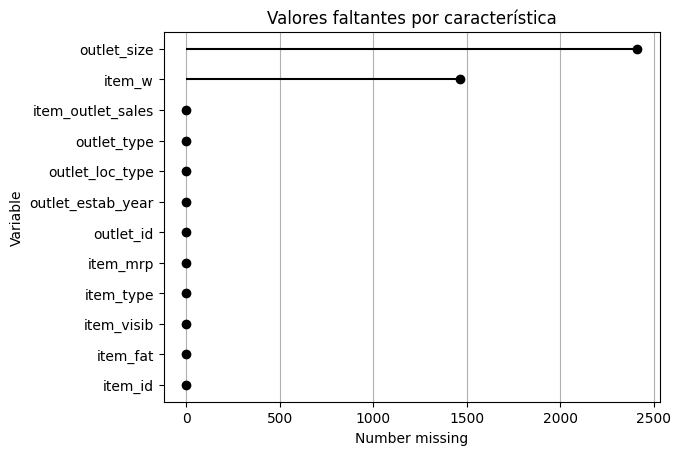

In [15]:
df.missing.missing_variable_plot()
plt.title('Valores faltantes por característica')

Se muestra que outlet_size e item_w tienen un alto porcentaje de nulos: 28.3% (2 410 valores) y 17.2% (1 463) respectivamente.

##Nulos por filas

In [16]:
nulos_filas_df = df.missing.missing_case_table().sort_values(by='n_missing_in_case')
nulos_filas_df

,n_missing_in_case,n_cases,pct_case
0,0,4650,54.558254
1,1,3873,45.441746


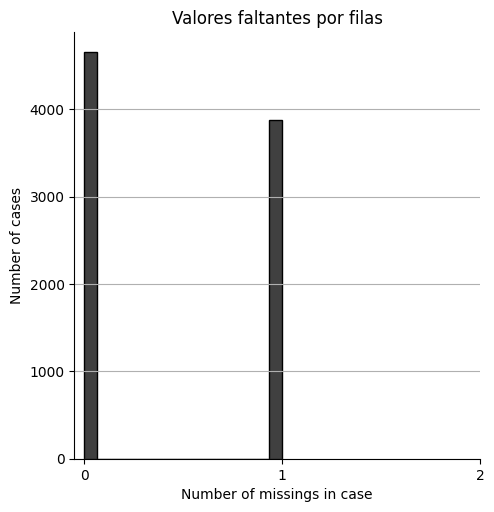

In [17]:
df.missing.missing_case_plot()
plt.xticks(range(0, 3, 1))
plt.title('Valores faltantes por filas');

Cerca de la mitad de los registros (45.4%) tienen 1 valor faltante.

##Nulos por columnas y filas

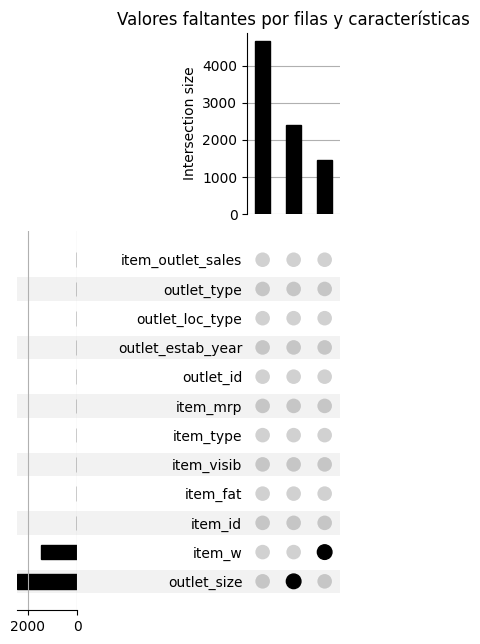

In [18]:
df.missing.missing_upsetplot(
        variables = None,
        element_size = 30)
plt.title('Valores faltantes por filas y características');

- Se observa gráficamente lo que se dijo antes, no existen filas con más de un valor faltante. Cuando falta el valor de item_w, outlet_size está completo, y viceversa.

##Matriz de nulidad

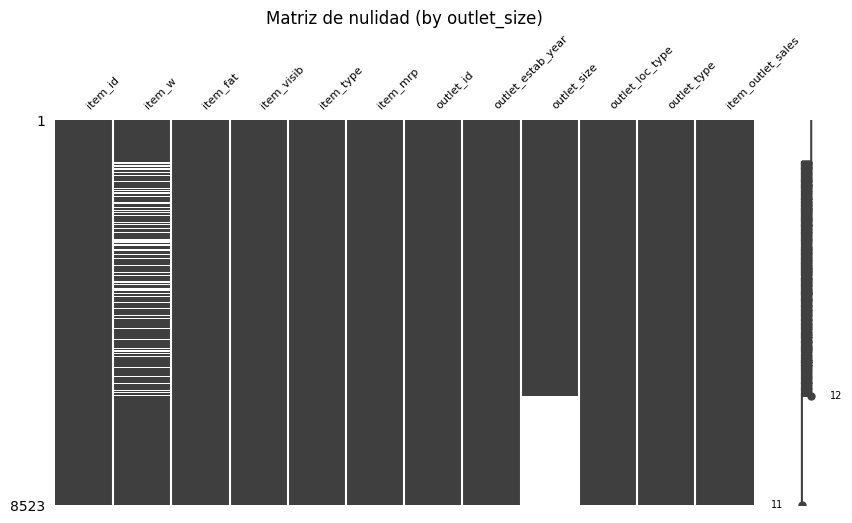

In [19]:
missingno.matrix(df.sort_values('outlet_size'), figsize=(10, 5), fontsize=8)
plt.title('Matriz de nulidad (by outlet_size)');

Las tiendas de tamaño High tienen sus registro completos.

In [20]:
outlet_size_high = df[df['outlet_size']=='High']
outlet_size_high.isna().sum()

item_id              0
item_w               0
item_fat             0
item_visib           0
item_type            0
item_mrp             0
outlet_id            0
outlet_estab_year    0
outlet_size          0
outlet_loc_type      0
outlet_type          0
item_outlet_sales    0
dtype: int64

#Imputación de valores faltantes

##item_w

'item_w' es el peso de cada producto e 'item_id' es el código único para cada producto. Si cada producto tiene un peso único, podría imputarse este peso a cada producto que le falte este valor. Veamos los datos de estas dos características:

In [21]:
df[['item_id', 'item_w']].sort_values(by='item_id').head(20).T

,8043,118,1693,1197,1245,7467,8195,6863,2879,4416,4900,4130,1148,3927,1876,6338,3962,8371,6179,6057
item_id,DRA12,DRA12,DRA12,DRA12,DRA12,DRA12,DRA24,DRA24,DRA24,DRA24,DRA24,DRA24,DRA24,DRA59,DRA59,DRA59,DRA59,DRA59,DRA59,DRA59
item_w,11.6,11.6,11.6,11.6,11.6,11.6,19.35,19.35,NaN,NaN,19.35,19.35,19.35,8.27,8.27,8.27,8.27,8.27,NaN,NaN


Al parecer cada producto tiene un peso único, veamos si se cumple en todos los casos.

In [22]:
unicos_item_id_item_w = df[['item_id', 'item_w']].groupby('item_id')['item_w'].unique().reset_index()
unicos_item_id_item_w.T

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
item_id,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,NCZ05,NCZ06,NCZ17,NCZ18,NCZ29,NCZ30,NCZ41,NCZ42,NCZ53,NCZ54
item_w,[11.6],"[19.35, nan]","[8.27, nan]","[7.39, nan]",[6.115],[8.785],"[12.3, nan]","[16.75, nan]","[5.92, nan]",[17.85],...,"[8.485, nan]","[nan, 19.6]","[nan, 12.15]","[7.825, nan]",[15.0],"[6.59, nan]",[19.85],[10.5],"[9.6, nan]","[14.65, nan]"


In [23]:
def longitud_lista(lista):
    return len(lista)

unicos_item_id_item_w['Longitud_Lista'] = unicos_item_id_item_w['item_w'].apply(longitud_lista)

In [24]:
unicos_item_id_item_w.T

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
item_id,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,NCZ05,NCZ06,NCZ17,NCZ18,NCZ29,NCZ30,NCZ41,NCZ42,NCZ53,NCZ54
item_w,[11.6],"[19.35, nan]","[8.27, nan]","[7.39, nan]",[6.115],[8.785],"[12.3, nan]","[16.75, nan]","[5.92, nan]",[17.85],...,"[8.485, nan]","[nan, 19.6]","[nan, 12.15]","[7.825, nan]",[15.0],"[6.59, nan]",[19.85],[10.5],"[9.6, nan]","[14.65, nan]"
Longitud_Lista,1,2,2,2,1,1,2,2,2,1,...,2,2,2,2,1,2,1,1,2,2


In [25]:
unicos_item_id_item_w.Longitud_Lista.value_counts()

Longitud_Lista
2    1138
1     421
Name: count, dtype: int64

Hay productos que tienen dos registros diferentes, pero se debe tener en cuenta que hay casos donde hay un valor faltante y lo está contabilizando como un registro más. Se debe comprobar si uno de los dos registros es un valor faltante.

In [26]:
filtro_longitud_lista_2 = unicos_item_id_item_w[unicos_item_id_item_w['Longitud_Lista']==2]

In [27]:
def contar_nulos(lista):
    return sum(pd.isnull(x) for x in lista)

filtro_longitud_lista_2['Nulos_En_Lista'] = filtro_longitud_lista_2['item_w'].apply(contar_nulos)

<ipython-input-27-bf810411b94b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_longitud_lista_2['Nulos_En_Lista'] = filtro_longitud_lista_2['item_w'].apply(contar_nulos)


In [28]:
filtro_longitud_lista_2.T

,1,2,3,6,7,8,12,14,15,17,...,1545,1547,1548,1549,1550,1551,1552,1554,1557,1558
item_id,DRA24,DRA59,DRB01,DRB25,DRB48,DRC01,DRC25,DRC36,DRC49,DRD12,...,NCY41,NCY53,NCY54,NCZ05,NCZ06,NCZ17,NCZ18,NCZ30,NCZ53,NCZ54
item_w,"[19.35, nan]","[8.27, nan]","[7.39, nan]","[12.3, nan]","[16.75, nan]","[5.92, nan]","[nan, 5.73]","[nan, 13.0]","[nan, 8.67]","[6.96, nan]",...,"[16.75, nan]","[20.0, nan]","[8.43, nan]","[8.485, nan]","[nan, 19.6]","[nan, 12.15]","[7.825, nan]","[6.59, nan]","[9.6, nan]","[14.65, nan]"
Longitud_Lista,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Nulos_En_Lista,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [29]:
filtro_longitud_lista_2.Nulos_En_Lista.value_counts()

Nulos_En_Lista
1    1138
Name: count, dtype: int64

Se confirma que cada producto donde registraba dos valores para el peso, un valor le correspondía a un nulo. Finalmente, se concluye que, a cada 'item_id' le corresponde un único 'item_w', lo que quiere decir que en algunos casos donde 'item_w' tiene valores faltantes los vamos a poder recuperar con el valor de la otra fila correspondiente al mismo producto.

A continuación generamos un nuevo df y lo usaremos para hacer merge con nuestro df original:

In [30]:
df_w=df.groupby(["item_id"])[["item_w"]].max().reset_index()
df_w.rename(columns = {'item_w' : 'item_w_new'}, inplace = True)
df_w

,item_id,item_w_new
0,DRA12,11.600
1,DRA24,19.350
2,DRA59,8.270
3,DRB01,7.390
4,DRB13,6.115
...,...,...
1554,NCZ30,6.590
1555,NCZ41,19.850
1556,NCZ42,10.500
1557,NCZ53,9.600


In [31]:
df_new = pd.merge(left=df, right=df_w, left_on="item_id", right_on="item_id", how="inner")
df_new.sort_values(by='item_id').head(20)

,item_id,item_w,item_fat,item_visib,item_type,item_mrp,outlet_id,outlet_estab_year,outlet_size,outlet_loc_type,outlet_type,item_outlet_sales,item_w_new
680,DRA12,11.60,Low Fat,0.041113,Soft Drinks,142.0154,OUT018,2009,Medium,Tier 3,Supermarket Type2,850.8924,11.60
678,DRA12,11.60,Low Fat,0.040912,Soft Drinks,142.3154,OUT013,1987,High,Tier 3,Supermarket Type1,2552.6772,11.60
677,DRA12,11.60,Low Fat,0.000000,Soft Drinks,141.6154,OUT045,2002,NaN,Tier 2,Supermarket Type1,3829.0158,11.60
676,DRA12,11.60,Low Fat,0.041178,Soft Drinks,140.3154,OUT017,2007,NaN,Tier 2,Supermarket Type1,2552.6772,11.60
681,DRA12,11.60,Low Fat,0.068535,Soft Drinks,143.0154,OUT010,1998,NaN,Tier 3,Grocery Store,283.6308,11.60
679,DRA12,11.60,Low Fat,0.000000,Soft Drinks,141.9154,OUT035,2004,Small,Tier 2,Supermarket Type1,992.7078,11.60
4801,DRA24,19.35,Regular,0.066832,Soft Drinks,163.8868,OUT010,1998,NaN,Tier 3,Grocery Store,327.5736,19.35
4805,DRA24,19.35,Regular,0.039895,Soft Drinks,162.4868,OUT013,1987,High,Tier 3,Supermarket Type1,4422.2436,19.35
4804,DRA24,19.35,Regular,0.039990,Soft Drinks,165.0868,OUT049,1999,Medium,Tier 1,Supermarket Type1,982.7208,19.35
4800,DRA24,NaN,Regular,0.069909,Soft Drinks,163.2868,OUT019,1985,Small,Tier 1,Grocery Store,491.3604,19.35


Al final de la tabla se observa la característica 'item_w_new' la cual contiene los valores del peso ya imputados.

In [32]:
df_new.isnull().sum()

item_id                 0
item_w               1463
item_fat                0
item_visib              0
item_type               0
item_mrp                0
outlet_id               0
outlet_estab_year       0
outlet_size          2410
outlet_loc_type         0
outlet_type             0
item_outlet_sales       0
item_w_new              4
dtype: int64

Los valores nulos se redujeron considerablemente de 1463 a 4. Veamos lo que sucede en estas cuatro filas que contienen los valores perdidos:

In [33]:
item_w_new_missing = df_new['item_w_new'].isna()
df_new.loc[item_w_new_missing, :]

,item_id,item_w,item_fat,item_visib,item_type,item_mrp,outlet_id,outlet_estab_year,outlet_size,outlet_loc_type,outlet_type,item_outlet_sales,item_w_new
4125,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564,NaN
6440,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280,NaN
8278,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046,NaN
8463,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098,NaN


Se debe comprobar que del DataFrame original (df) estos valores 'item_id' se repitan una sola vez:

In [34]:
df_id = df.loc[(df['item_id'] == 'FDN52') | (df['item_id'] == 'FDK57') | (df['item_id'] == 'FDE52') | (df['item_id'] == 'FDQ60'), :]
df_id['item_id'].value_counts()

item_id
FDN52    1
FDK57    1
FDE52    1
FDQ60    1
Name: count, dtype: int64

Dado que se comprueba que los productos se repiten una vez y no se puede usar otra columna para recuperar estos 4 valores, se opta por eliminar las filas con valores perdidos que representan una mínima parte de nuestro dataset (0.05%).



In [35]:
4/8523*100

0.04693183151472486

In [36]:
df_new = df_new.dropna(subset=['item_w_new'])

Se elimina 'item_w':

In [37]:
df_new = df_new.drop('item_w', axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            8519 non-null   object 
 1   item_fat           8519 non-null   object 
 2   item_visib         8519 non-null   float64
 3   item_type          8519 non-null   object 
 4   item_mrp           8519 non-null   float64
 5   outlet_id          8519 non-null   object 
 6   outlet_estab_year  8519 non-null   int64  
 7   outlet_size        6109 non-null   object 
 8   outlet_loc_type    8519 non-null   object 
 9   outlet_type        8519 non-null   object 
 10  item_outlet_sales  8519 non-null   float64
 11  item_w_new         8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


##outle_size

Similar a lo que pasaba con el peso de los productos, podríamos usar la característica 'outlet_id' para recuperar los valores perdidos. Veamos los datos de estas dos columnas:

In [38]:
outlet_size_missing = df_new['outlet_size'].isna()
df_new.loc[outlet_size_missing, :].head(30)

,item_id,item_fat,item_visib,item_type,item_mrp,outlet_id,outlet_estab_year,outlet_size,outlet_loc_type,outlet_type,item_outlet_sales,item_w_new
1,FDA15,Low Fat,0.016055,Dairy,250.2092,OUT045,2002,NaN,Tier 2,Supermarket Type1,5976.2208,9.300
4,FDA15,Low Fat,0.026818,Dairy,248.9092,OUT010,1998,NaN,Tier 3,Grocery Store,498.0184,9.300
7,FDA15,Low Fat,0.016113,Dairy,248.8092,OUT017,2007,NaN,Tier 2,Supermarket Type1,5976.2208,9.300
9,DRC01,Regular,0.019309,Soft Drinks,49.0692,OUT017,2007,NaN,Tier 2,Supermarket Type1,1478.0760,5.920
11,DRC01,Regular,0.019239,Soft Drinks,49.8692,OUT045,2002,NaN,Tier 2,Supermarket Type1,1133.1916,5.920
15,FDN15,Low Fat,0.028009,Meat,141.7180,OUT010,1998,NaN,Tier 3,Grocery Store,419.4540,17.500
18,FDN15,Low Fat,0.016768,Meat,141.4180,OUT045,2002,NaN,Tier 2,Supermarket Type1,1957.4520,17.500
21,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,19.200
23,FDX07,Regular,0.022965,Fruits and Vegetables,181.6950,OUT045,2002,NaN,Tier 2,Supermarket Type1,2563.3300,19.200
28,NCD19,Low Fat,0.022060,Household,56.0614,OUT010,1998,NaN,Tier 3,Grocery Store,276.3070,8.930


Los valores que se repiten de 'outlet_id' que corresponden a los valores NaN de 'outlet_size' son:
- OUT045
- OUT010
- OUT017

In [39]:
outlet_45_10_17 = df_new.loc[(df_new['outlet_id'] == 'OUT045') | (df_new['outlet_id'] == 'OUT010') | (df_new['outlet_id'] == 'OUT017'), :]

In [40]:
print(outlet_45_10_17['outlet_id'].value_counts())
outlet_45_10_17['outlet_id'].value_counts().sum()

outlet_id
OUT045    929
OUT017    926
OUT010    555
Name: count, dtype: int64


2410

La suma es 2410, que es exactamente el número de valores perdidos de nuestro DataFrame para esta característica, lo que nos indica que no podemos recuperar datos perdidos usando 'outlet_id'.

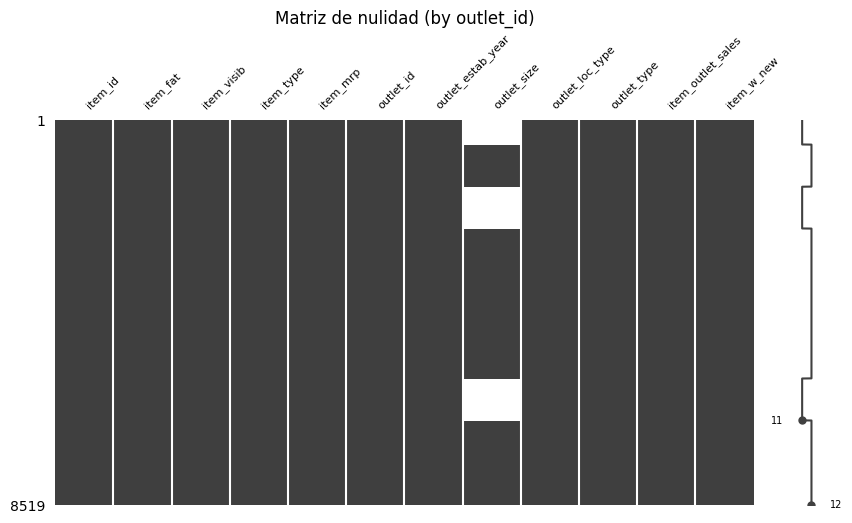

In [41]:
missingno.matrix(df_new.sort_values('outlet_id'), figsize=(10, 5), fontsize=8)
plt.title('Matriz de nulidad (by outlet_id)');

Veamos qué relaciones podemos encontrar con otras características de la tienda a continuación:

In [42]:
outlet_otros=df_new.groupby(["outlet_type", "outlet_loc_type", "outlet_id"])[["outlet_size", 'item_outlet_sales']].max().reset_index()
outlet_otros.sort_values(by=['outlet_type', 'outlet_loc_type', "outlet_id"])

,outlet_type,outlet_loc_type,outlet_id,outlet_size,item_outlet_sales
0,Grocery Store,Tier 1,OUT019,Small,1482.0708
1,Grocery Store,Tier 3,OUT010,NaN,1775.6886
2,Supermarket Type1,Tier 1,OUT046,Small,9779.9362
3,Supermarket Type1,Tier 1,OUT049,Medium,7646.0472
4,Supermarket Type1,Tier 2,OUT017,NaN,9664.7528
5,Supermarket Type1,Tier 2,OUT035,Small,8479.6288
6,Supermarket Type1,Tier 2,OUT045,NaN,8994.9580
7,Supermarket Type1,Tier 3,OUT013,High,10256.6490
8,Supermarket Type2,Tier 3,OUT018,Medium,6768.5228
9,Supermarket Type3,Tier 3,OUT027,Medium,13086.9648


- No se observa relación entre las características que nos ayuden a imputar los valores faltantes en outlet_size.
- Al observar 'Supermarket Type1' y 'Tier 1' concluimos que si la tienda tiene estas dos características, no necesariamente será de un solo tamaño, puede ser Small o Medium. Por tanto, no pueden ser imputadas las tiendas que tienen las características 'Supermarket Type1' y 'Tier 2' con Small porque hay la posibilidad de que sean de otro tamaño.
- Por lo anterior y dado que el porcentaje de nulos es alto, se decide eliminar toda la característica 'outlet_size'.

In [43]:
df_new.drop('outlet_size', axis=1, inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            8519 non-null   object 
 1   item_fat           8519 non-null   object 
 2   item_visib         8519 non-null   float64
 3   item_type          8519 non-null   object 
 4   item_mrp           8519 non-null   float64
 5   outlet_id          8519 non-null   object 
 6   outlet_estab_year  8519 non-null   int64  
 7   outlet_loc_type    8519 non-null   object 
 8   outlet_type        8519 non-null   object 
 9   item_outlet_sales  8519 non-null   float64
 10  item_w_new         8519 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 798.7+ KB


#Valores atípicos

In [44]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
item_visib,8519.0,0.066112,0.051586,0.000,0.026983,0.053925,0.094558,0.328391
item_mrp,8519.0,141.010019,62.283594,31.290,93.844900,143.047000,185.676600,266.888400
outlet_estab_year,8519.0,1997.837892,8.369105,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
item_outlet_sales,8519.0,2181.188779,1706.511093,33.290,834.247400,1794.331000,3100.630600,13086.964800
item_w_new,8519.0,12.875420,4.646098,4.555,8.785000,12.650000,16.850000,21.350000


'item_visib' es la visibilidad del producto en la tienda. Un valor de cero no es normal ya que implica que el producto no
se excibe y, sin embargo, tiene ventas. Por tanto, ese cero será tratado como un valor nulo, suponiendo que no se obtuvo la información y se optó por registrarlo como cero.

In [45]:
atipico = df_new[['item_id', 'item_w_new', 'item_visib', 'outlet_id', 'item_outlet_sales']]
atipico

,item_id,item_w_new,item_visib,outlet_id,item_outlet_sales
0,FDA15,9.300,0.016047,OUT049,3735.1380
1,FDA15,9.300,0.016055,OUT045,5976.2208
2,FDA15,9.300,0.016019,OUT035,6474.2392
3,FDA15,9.300,0.016088,OUT018,5976.2208
4,FDA15,9.300,0.026818,OUT010,498.0184
...,...,...,...,...,...
8518,NCF55,6.675,0.021666,OUT046,1235.0590
8519,NCW30,5.210,0.011072,OUT017,4402.9354
8520,NCW30,5.210,0.011008,OUT035,2848.9582
8521,NCW05,20.250,0.148303,OUT049,2787.0388


In [46]:
unicos_item_visib = atipico.groupby(['item_id', 'outlet_id'])['item_visib'].unique().reset_index()
unicos_item_visib

,item_id,outlet_id,item_visib
0,DRA12,OUT010,[0.068535039]
1,DRA12,OUT013,[0.040911824]
2,DRA12,OUT017,[0.041177505]
3,DRA12,OUT018,[0.041112694]
4,DRA12,OUT035,[0.0]
...,...,...,...
8514,NCZ54,OUT019,[0.145951533]
8515,NCZ54,OUT027,[0.082955719]
8516,NCZ54,OUT045,[0.083528446]
8517,NCZ54,OUT046,[0.083359391]


In [47]:
def longitud_lista(lista):
    return len(lista)
unicos_item_visib['Longitud_Lista'] = unicos_item_visib['item_visib'].apply(longitud_lista)

In [48]:
unicos_item_visib

,item_id,outlet_id,item_visib,Longitud_Lista
0,DRA12,OUT010,[0.068535039],1
1,DRA12,OUT013,[0.040911824],1
2,DRA12,OUT017,[0.041177505],1
3,DRA12,OUT018,[0.041112694],1
4,DRA12,OUT035,[0.0],1
...,...,...,...,...
8514,NCZ54,OUT019,[0.145951533],1
8515,NCZ54,OUT027,[0.082955719],1
8516,NCZ54,OUT045,[0.083528446],1
8517,NCZ54,OUT046,[0.083359391],1


In [49]:
unicos_item_visib['Longitud_Lista'].value_counts()

Longitud_Lista
1    8519
Name: count, dtype: int64

Aquí comprobamos que cada producto tiene un solo valor de visibilidad para cada tienda, lo que implica que donde hay un valor de cero no podrá ser imputado porque no hay otro registro que podamos usar de referencia.

In [50]:
df_new['item_visib'].value_counts()

item_visib
0.000000    526
0.076975      3
0.045166      2
0.034868      2
0.103442      2
           ... 
0.029693      1
0.049499      1
0.029633      1
0.051778      1
0.148373      1
Name: count, Length: 7876, dtype: int64

In [51]:
526/8519*100

6.1744336189693625

Correlación con ceros en 'item_visib':

<Axes: >

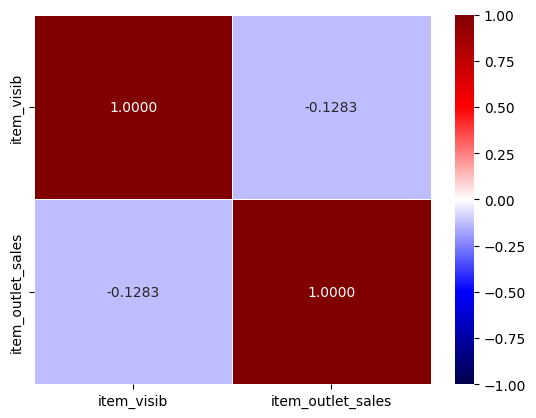

In [52]:
corr = df_new[['item_visib', 'item_outlet_sales']].corr()
sns.heatmap(corr, annot=True, cmap='seismic', fmt=".4f", linewidth=.5,
            vmin=-1, vmax=1)

Correlación sin ceros en 'item_visib':

In [53]:
visib_sin_ceros = df_new[df_new['item_visib']!=0]

<Axes: >

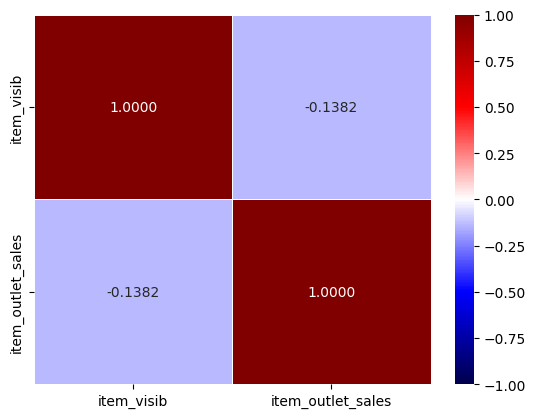

In [54]:
corr = visib_sin_ceros[['item_visib', 'item_outlet_sales']].corr()
sns.heatmap(corr, annot=True, cmap='seismic', fmt=".4f", linewidth=.5,
            vmin=-1, vmax=1)

Aunque los valores faltantes de 'item_visib' no representan un porcentaje alto del total de registros, no se optará por eliminar las filas con nulos. En su lugar, dado que la correlación con las ventas es baja (y de dirección contraria a la esperada) tanto si condieramos los valores de cero como sin considerarlos, se toma la deciisón de eliminar 'item_visib'

In [55]:
df_new = df_new.drop('item_visib', axis=1)

In [56]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            8519 non-null   object 
 1   item_fat           8519 non-null   object 
 2   item_type          8519 non-null   object 
 3   item_mrp           8519 non-null   float64
 4   outlet_id          8519 non-null   object 
 5   outlet_estab_year  8519 non-null   int64  
 6   outlet_loc_type    8519 non-null   object 
 7   outlet_type        8519 non-null   object 
 8   item_outlet_sales  8519 non-null   float64
 9   item_w_new         8519 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 732.1+ KB


In [57]:
df_cln= df_new.copy(deep = True)

df_cln es el DataFrame limpio.

#Distribuciones de los datos

In [58]:
continuas = ['item_w_new', 'item_mrp', 'item_outlet_sales']
categoricas = ['outlet_estab_year', 'item_type', 'outlet_id', 'item_fat', 'outlet_loc_type', 'outlet_type']

##Distribución de las variables numéricas

In [59]:
continuas

['item_w_new', 'item_mrp', 'item_outlet_sales']

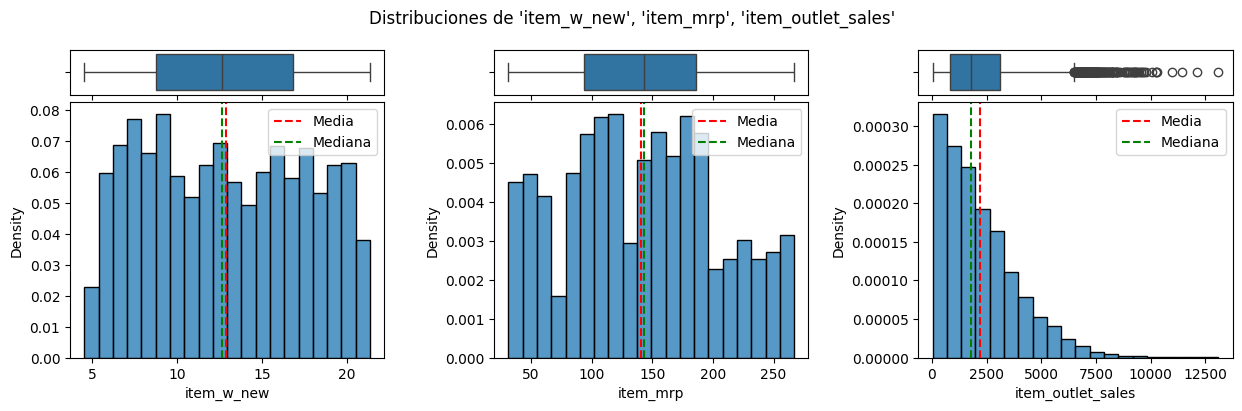

In [60]:
fig, ax = plt.subplots(2, 3, sharex=False, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 4))

conteo1 = []
conteo2 = []

for i in range(1, 7):
  if (i == 1 or i == 2 or i == 3):
    ax_i = plt.subplot(2,3,i)
    conteo1.append(i)
    for j in range(1, len(continuas)+1):
      if j == len(conteo1):
        posicion = conteo1[j-1]
        sns.boxplot(df_cln[continuas[j-1]], orient="h", ax=ax_i)
        ax_i.set_xticklabels([])
        ax_i.set_xlabel("")

  else:
    ax_i = plt.subplot(2,3,i)
    conteo2.append(i)
    for j in range(1, len(continuas)+1):
      if j == len(conteo2):
        sns.histplot(data=df_cln[continuas[j-1]], bins=20, stat='density', ax=ax_i)
        plt.axvline(df_cln[continuas[j-1]].mean(), color='red', linestyle='dashed', linewidth=1.5, label='Media')
        plt.axvline(df_cln[continuas[j-1]].median(), color='green', linestyle='dashed', linewidth=1.5, label='Mediana')
        plt.legend()

plt.subplots_adjust(wspace=0.35, hspace=0.05)
fig.suptitle("Distribuciones de 'item_w_new', 'item_mrp', 'item_outlet_sales'");

- En este conjunto de datos, el peso de los productos va desde lo 4 a 21 kg., pero estos extremos no representan valores atípicos en la muestra. Tenemos una media y mediana muy cercanas (12.9 y 12.7 respectivamente) que además están centradas lo que es un indicador de simetría. Sin embargo, según la prueba Kolmogorov-Smirnov para normalidad los datos no siguen una distribución normal.

- Una distribución similar sigue el mrp, donde no hay valores atípicos, la media y mediana tienen valores parecidos (141 y 143 respectivamente).

- Por el contrario, las ventas de los productos por tienda tienen valores atípicos y la distribución está sesgada a la izquierda.

In [61]:
df_cln.describe().T

,count,mean,std,min,25%,50%,75%,max
item_mrp,8519.0,141.010019,62.283594,31.290,93.8449,143.047,185.6766,266.8884
outlet_estab_year,8519.0,1997.837892,8.369105,1985.000,1987.0000,1999.000,2004.0000,2009.0000
item_outlet_sales,8519.0,2181.188779,1706.511093,33.290,834.2474,1794.331,3100.6306,13086.9648
item_w_new,8519.0,12.875420,4.646098,4.555,8.7850,12.650,16.8500,21.3500


In [62]:
item_w_new = df_cln['item_w_new']
item_mrp = df_cln['item_mrp']
item_outlet_sales = df_cln['item_outlet_sales']

In [63]:
from scipy import stats

In [64]:
esn_media = np.mean(item_w_new)
esn_std = np.std(item_w_new)

esn_ks_stat, esn_ks_p_value = stats.kstest(item_w_new, cdf='norm', args=(esn_media, esn_std), N=len(item_w_new))

print('Estadístico=%.3f, p_value=%.3f' % (esn_ks_stat, esn_ks_p_value))

if esn_ks_p_value >= 0.05:
  print('Con 95% de confianza, los datos de edad son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.')
else:
  print('Con 95% de confianza, los datos de edad no son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.')

Estadístico=0.080, p_value=0.000
Con 95% de confianza, los datos de edad no son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.


In [65]:
esn_media = np.mean(item_mrp)
esn_std = np.std(item_mrp)

esn_ks_stat, esn_ks_p_value = stats.kstest(item_mrp, cdf='norm', args=(esn_media, esn_std), N=len(item_mrp))

print('Estadístico=%.3f, p_value=%.3f' % (esn_ks_stat, esn_ks_p_value))

if esn_ks_p_value >= 0.05:
  print('Con 95% de confianza, los datos de edad son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.')
else:
  print('Con 95% de confianza, los datos de edad no son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.')

Estadístico=0.045, p_value=0.000
Con 95% de confianza, los datos de edad no son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.


In [66]:
esn_media = np.mean(item_outlet_sales)
esn_std = np.std(item_outlet_sales)

esn_ks_stat, esn_ks_p_value = stats.kstest(item_outlet_sales, cdf='norm', args=(esn_media, esn_std), N=len(item_outlet_sales))

print('Estadístico=%.3f, p_value=%.3f' % (esn_ks_stat, esn_ks_p_value))

if esn_ks_p_value >= 0.05:
  print('Con 95% de confianza, los datos de edad son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.')
else:
  print('Con 95% de confianza, los datos de edad no son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.')

Estadístico=0.104, p_value=0.000
Con 95% de confianza, los datos de edad no son similares a una distribución normal, según la prueba de Kolmogorov-Smirnov.


##Distribución de las variables categóricas

In [67]:
categoricas

['outlet_estab_year',
 'item_type',
 'outlet_id',
 'item_fat',
 'outlet_loc_type',
 'outlet_type']

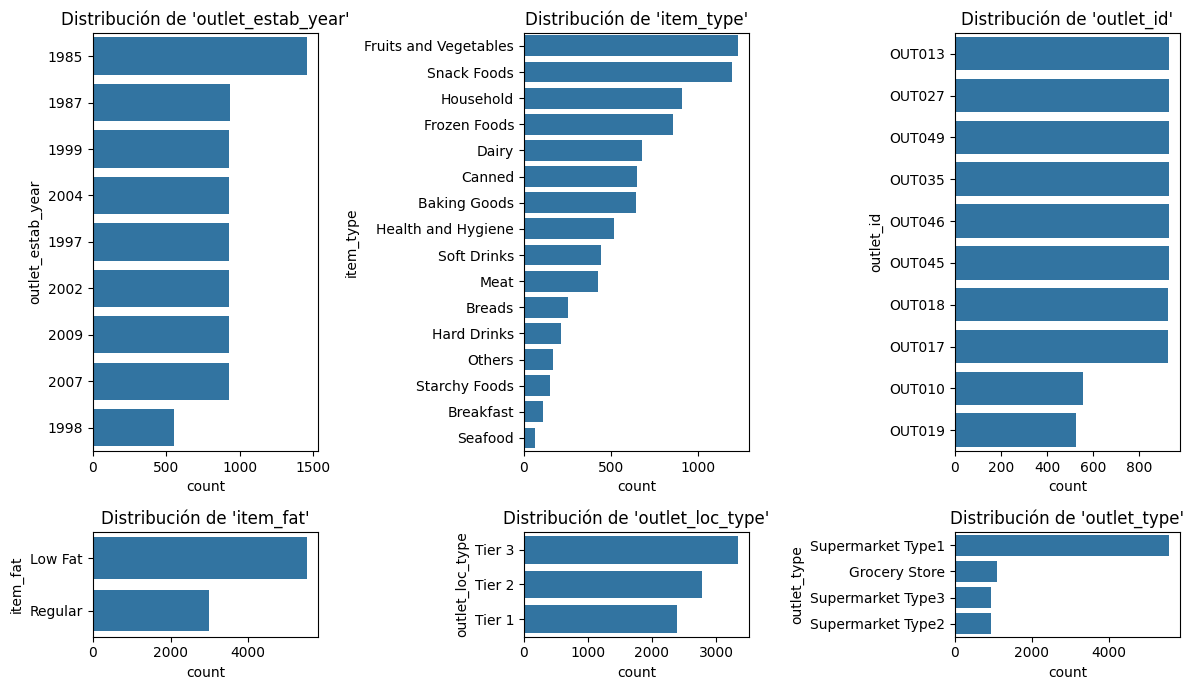

In [68]:
fig, axes = plt.subplots(2, 3, gridspec_kw={"height_ratios": (0.8, 0.2)}, figsize=(12, 7))

for i, ax in enumerate(axes.flatten()):
    if i < len(categoricas):
        ordered_categories = df_cln[categoricas[i]].value_counts().index
        sns.countplot(y=categoricas[i], data=df_cln, ax=ax, order=ordered_categories)
        ax.set_title(f"Distribución de '{categoricas[i]}'")
plt.tight_layout()
plt.show()

- Existen 10 tiendas. Dos de ellas se establecieron el mismo año: OUT019 Y OUT027 en 1985.
- La mayoría de los productos son de la categoría de frutas y vegetales, seguido de los aperitivos.
- Las tiendas OUT013 Y OUT027 tienen el mayor número de productos (932 productos).
- La mayoría de los productos son bajos en grasas.
- El tipo de área con la mayor variedad de productos es el Nivel 3.
- Las tiendas de tipo Supermercado Tipo 1 venden una mayor variedad de productos.

In [69]:
df_cln.groupby(['outlet_id', 'outlet_estab_year'])['outlet_estab_year'].count()

outlet_id  outlet_estab_year
OUT010     1998                 555
OUT013     1987                 932
OUT017     2007                 926
OUT018     2009                 928
OUT019     1985                 527
OUT027     1985                 932
OUT035     2004                 930
OUT045     2002                 929
OUT046     1997                 930
OUT049     1999                 930
Name: outlet_estab_year, dtype: int64

#Relación entre las ventas y las demás características

In [70]:
y_cat = df_cln[['outlet_estab_year', 'item_type', 'outlet_id', 'item_fat', 'outlet_loc_type', 'outlet_type', 'item_outlet_sales']]

In [71]:
y_cat['outlet_estab_year'] = y_cat['outlet_estab_year'].astype(str)

<ipython-input-71-b9f7e0171a64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_cat['outlet_estab_year'] = y_cat['outlet_estab_year'].astype(str)


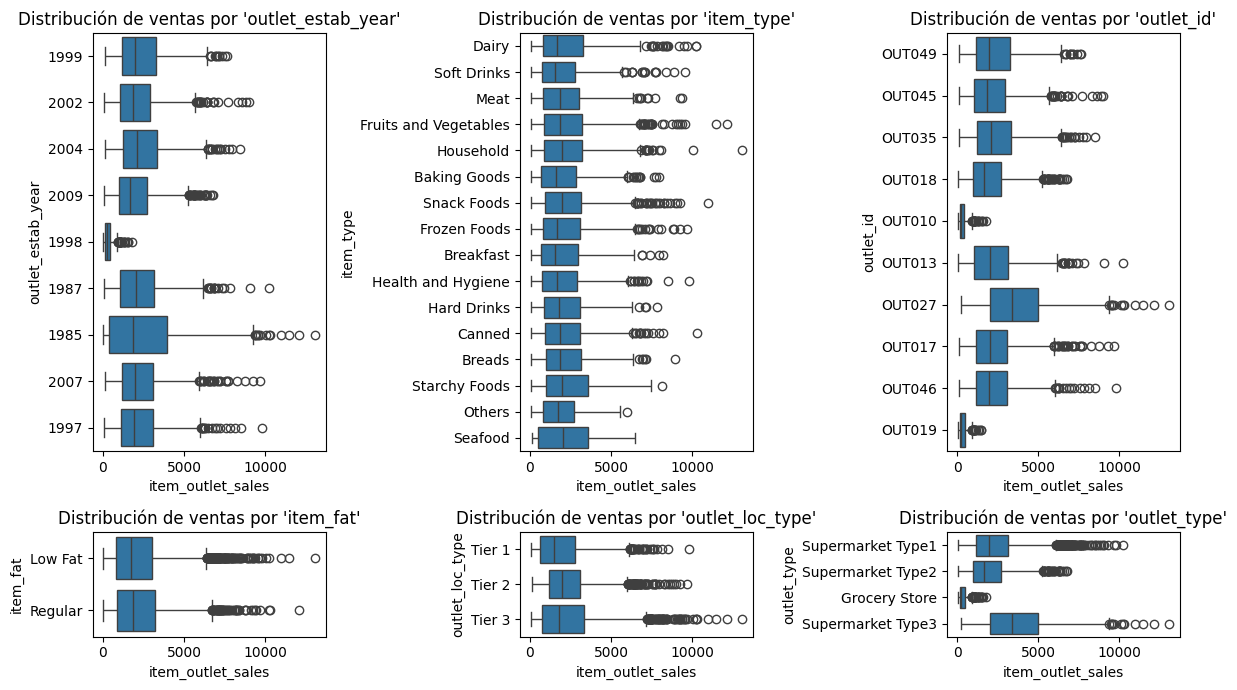

In [72]:
fig, axes = plt.subplots(2, 3, gridspec_kw={"height_ratios": (0.8, 0.2)}, figsize=(12, 7))
for i, ax in enumerate(axes.flatten()):
    if i < len(categoricas):
        sns.boxplot(data=y_cat, y=categoricas[i], x='item_outlet_sales', ax=ax)
        ax.set_title(f"Distribución de ventas por '{categoricas[i]}'")
plt.tight_layout()
plt.show()

- La tienda OUT010 y OUT019 tienen un rango de ventas menor (y promedio menor) que el resto, mientras que OUT027 tiene el mayor rango (y mayor promedio).
- Seafood es la  única categoría de producto que no tiene valores atípicos por ventas.
- No hay mucha diferencia en la distribución de las ventas por el nivel de grasa de los productos.
- El Nivel 3 tiene valores atípicos más altos que los otros niveles.
- Las tiendas que son Supermercados de tipo 3, tiene ventas más altas y las que son Grocery Store las más bajas.

In [73]:
continuas

['item_w_new', 'item_mrp', 'item_outlet_sales']

In [74]:
continuas.pop(-1)
continuas

['item_w_new', 'item_mrp']

In [75]:
y_num = df_cln[['item_w_new', 'item_mrp', 'item_outlet_sales']]

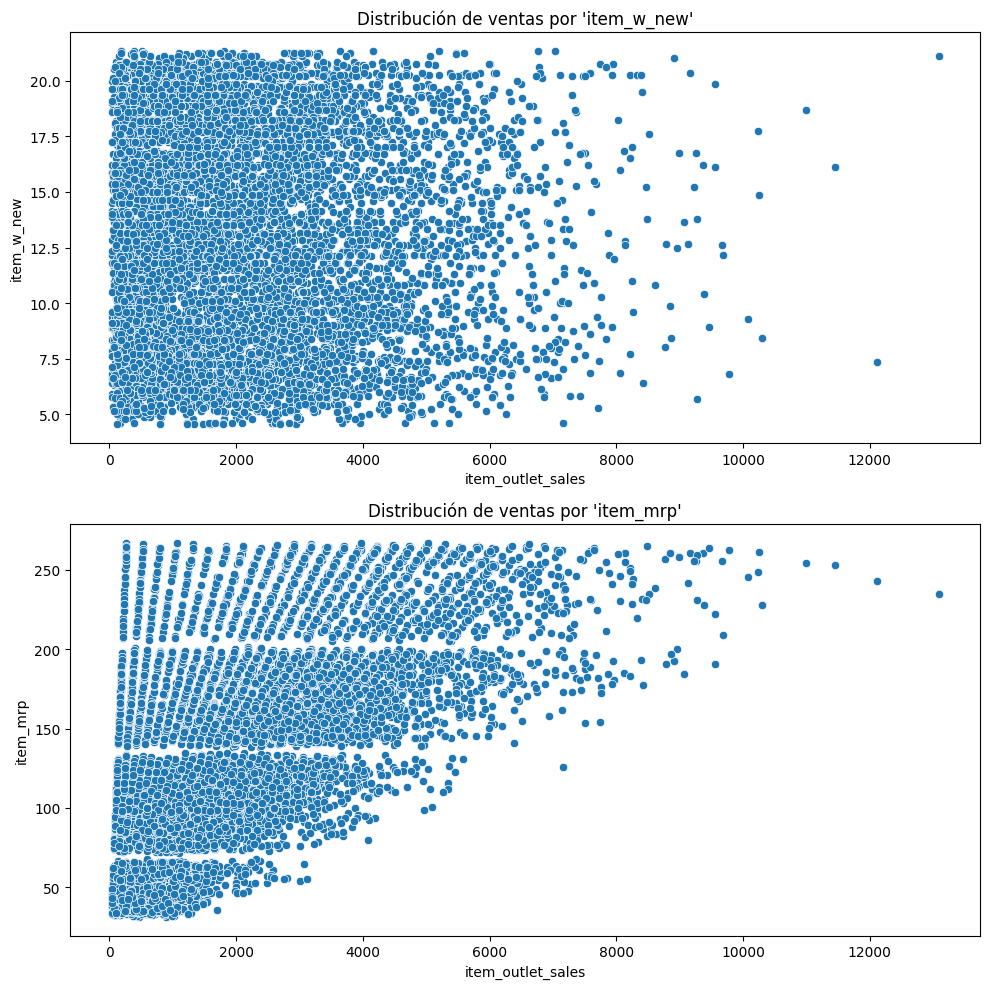

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    if i < len(continuas):
        sns.scatterplot(data=y_num, y=continuas[i], x='item_outlet_sales', ax=ax)
        ax.set_title(f"Distribución de ventas por '{continuas[i]}'")

plt.tight_layout()
plt.show()

- Parece no existir relación entre el peso de los productos y las ventas.
- Se observa una relación positiva entre las ventas y el precio.

#Eliminamos características no relevantes para el modelamiento

In [77]:
df_cln.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            8519 non-null   object 
 1   item_fat           8519 non-null   object 
 2   item_type          8519 non-null   object 
 3   item_mrp           8519 non-null   float64
 4   outlet_id          8519 non-null   object 
 5   outlet_estab_year  8519 non-null   int64  
 6   outlet_loc_type    8519 non-null   object 
 7   outlet_type        8519 non-null   object 
 8   item_outlet_sales  8519 non-null   float64
 9   item_w_new         8519 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 732.1+ KB


In [78]:
df_cln.drop(['item_id', 'outlet_estab_year'], axis =1, inplace=True)
df_cln.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_fat           8519 non-null   object 
 1   item_type          8519 non-null   object 
 2   item_mrp           8519 non-null   float64
 3   outlet_id          8519 non-null   object 
 4   outlet_loc_type    8519 non-null   object 
 5   outlet_type        8519 non-null   object 
 6   item_outlet_sales  8519 non-null   float64
 7   item_w_new         8519 non-null   float64
dtypes: float64(3), object(5)
memory usage: 599.0+ KB


In [79]:
df_cln.rename(columns = {'item_w_new' : 'item_w'}, inplace = True)
df_cln.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_fat           8519 non-null   object 
 1   item_type          8519 non-null   object 
 2   item_mrp           8519 non-null   float64
 3   outlet_id          8519 non-null   object 
 4   outlet_loc_type    8519 non-null   object 
 5   outlet_type        8519 non-null   object 
 6   item_outlet_sales  8519 non-null   float64
 7   item_w             8519 non-null   float64
dtypes: float64(3), object(5)
memory usage: 599.0+ KB


#Separamos el target (y) de las features (X)

In [80]:
y = df_cln['item_outlet_sales']
y.shape

(8519,)

In [81]:
X = df_cln.drop('item_outlet_sales', axis=1)
X.shape

(8519, 7)

In [82]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   item_fat         8519 non-null   object 
 1   item_type        8519 non-null   object 
 2   item_mrp         8519 non-null   float64
 3   outlet_id        8519 non-null   object 
 4   outlet_loc_type  8519 non-null   object 
 5   outlet_type      8519 non-null   object 
 6   item_w           8519 non-null   float64
dtypes: float64(2), object(5)
memory usage: 532.4+ KB


#PRE-PROCESAMIENTO: Transformación de X

##Selección de variables

In [83]:
X.columns

Index(['item_fat', 'item_type', 'item_mrp', 'outlet_id', 'outlet_loc_type',
       'outlet_type', 'item_w'],
      dtype='object')

In [84]:
escalables = ['item_mrp', 'item_w']
nominales = ['item_type', 'outlet_id', 'outlet_type']
item_fat = ['item_fat']
outlet_loc_type = ['outlet_loc_type']

###Tranformadores

In [85]:
orden_item_fat = ['Low Fat', 'Regular']
orden_outlet_loc_type = ['Tier 3', 'Tier 2', 'Tier 1']

In [86]:
standard_scaler = StandardScaler()
ordinal_encoder_item_fat = OrdinalEncoder(categories=[orden_item_fat])
ordinal_encoder_outlet_loc_type = OrdinalEncoder(categories=[orden_outlet_loc_type])
one_hot_encoder = OneHotEncoder()

###Imputadores

In [87]:
imputer_numericos = SimpleImputer(strategy="mean")
imputer_ordinales = SimpleImputer(strategy="most_frequent")
imputer_nominales = SimpleImputer(strategy="most_frequent")

###Transformación

In [88]:
col_transformer = make_column_transformer((make_pipeline(standard_scaler, imputer_numericos), escalables),
                                          (make_pipeline(ordinal_encoder_item_fat, imputer_ordinales), item_fat),
                                          (make_pipeline(ordinal_encoder_outlet_loc_type, imputer_ordinales), outlet_loc_type),
                                          (make_pipeline(one_hot_encoder, imputer_nominales), nominales),
                                          remainder = 'passthrough')

col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer())]),
                                 ['item_mrp', 'item_w']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Low '
                                                                              'Fat',
                                                                              'Regular']])),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['item_f...
                                ('pipeline-3',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Tier '
                                                                              '3',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '1']])),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['outlet_loc_type']),
                                ('pipeline-4',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder()),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['item_type', 'outlet_id', 'outlet_type'])])

In [89]:
X

,item_fat,item_type,item_mrp,outlet_id,outlet_loc_type,outlet_type,item_w
0,Low Fat,Dairy,249.8092,OUT049,Tier 1,Supermarket Type1,9.300
1,Low Fat,Dairy,250.2092,OUT045,Tier 2,Supermarket Type1,9.300
2,Low Fat,Dairy,248.5092,OUT035,Tier 2,Supermarket Type1,9.300
3,Low Fat,Dairy,249.6092,OUT018,Tier 3,Supermarket Type2,9.300
4,Low Fat,Dairy,248.9092,OUT010,Tier 3,Grocery Store,9.300
...,...,...,...,...,...,...,...
8518,Low Fat,Household,33.3874,OUT046,Tier 1,Supermarket Type1,6.675
8519,Low Fat,Household,257.8962,OUT017,Tier 2,Supermarket Type1,5.210
8520,Low Fat,Household,259.5962,OUT035,Tier 2,Supermarket Type1,5.210
8521,Low Fat,Health and Hygiene,108.3938,OUT049,Tier 1,Supermarket Type1,20.250


###X transformado

In [90]:
X_encoded = pd.DataFrame(col_transformer.fit_transform(X).toarray(),
                               columns = col_transformer.get_feature_names_out(),
                               index = X.index).rename_columns(
                                   function = lambda x: x.removeprefix('pipeline-1__')).rename_columns(
                                       function = lambda x: x.removeprefix('pipeline-2__')).rename_columns(
                                           function = lambda x: x.removeprefix('pipeline-3__')).rename_columns(
                                               function = lambda x: x.removeprefix('pipeline-4__')).rename_columns(
                                                   function = lambda x: x.removeprefix('remainder__'))
X_encoded

,item_mrp,item_w,item_fat,outlet_loc_type,item_type_Baking Goods,item_type_Breads,item_type_Breakfast,item_type_Canned,item_type_Dairy,item_type_Frozen Foods,...,outlet_id_OUT019,outlet_id_OUT027,outlet_id_OUT035,outlet_id_OUT045,outlet_id_OUT046,outlet_id_OUT049,outlet_type_Grocery Store,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3
0,1.746938,-0.769598,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.753360,-0.769598,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.726064,-0.769598,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.743727,-0.769598,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.732487,-0.769598,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,-1.728046,-1.334622,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8519,1.876787,-1.649959,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8520,1.904083,-1.649959,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8521,-0.523703,1.587356,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


##Separamos en train y test

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state = 77)

In [92]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5963 entries, 6591 to 2283
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   item_mrp                         5963 non-null   float64
 1   item_w                           5963 non-null   float64
 2   item_fat                         5963 non-null   float64
 3   outlet_loc_type                  5963 non-null   float64
 4   item_type_Baking Goods           5963 non-null   float64
 5   item_type_Breads                 5963 non-null   float64
 6   item_type_Breakfast              5963 non-null   float64
 7   item_type_Canned                 5963 non-null   float64
 8   item_type_Dairy                  5963 non-null   float64
 9   item_type_Frozen Foods           5963 non-null   float64
 10  item_type_Fruits and Vegetables  5963 non-null   float64
 11  item_type_Hard Drinks            5963 non-null   float64
 12  item_type_Health and H

#MODELO DE REGRESIÓN CON TODAS LAS FEATURES

###Parámetros del mejor modelo para árbol de decisión

In [93]:
param_grid_tree_reg = [{'max_depth':[1,2,3,4,5,6,7,8,9,10,
                                     11,12,13,14,15,16,17,18,19,20,
                                     21,22,23,24,25,26,27,28,29,30,
                                     31,32,33,34]}]

In [94]:
grid_tree_reg = DecisionTreeRegressor()

grid_search_tree_reg = GridSearchCV(grid_tree_reg, param_grid_tree_reg, cv=5,
                           return_train_score=True)

grid_search_tree_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                        23, 24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True)

In [95]:
cvres_tree_reg = grid_search_tree_reg.cv_results_
for values in zip(cvres_tree_reg['mean_test_score'], cvres_tree_reg['params']):
    print(values)

(0.22708559298771513, {'max_depth': 1})
(0.4308531314951127, {'max_depth': 2})
(0.5241530802772036, {'max_depth': 3})
(0.5797503699530181, {'max_depth': 4})
(0.5854915052942923, {'max_depth': 5})
(0.5786685746474605, {'max_depth': 6})
(0.5659946051505057, {'max_depth': 7})
(0.540822229196742, {'max_depth': 8})
(0.5123669244818151, {'max_depth': 9})
(0.49068652018747877, {'max_depth': 10})
(0.4594595170325504, {'max_depth': 11})
(0.43709680881671664, {'max_depth': 12})
(0.40753724584938683, {'max_depth': 13})
(0.37408019096571515, {'max_depth': 14})
(0.34483145088197054, {'max_depth': 15})
(0.32390431787240875, {'max_depth': 16})
(0.30472665390514, {'max_depth': 17})
(0.27731885041985127, {'max_depth': 18})
(0.26325085595781145, {'max_depth': 19})
(0.23573626662090758, {'max_depth': 20})
(0.231844130435834, {'max_depth': 21})
(0.22575599632013937, {'max_depth': 22})
(0.2176005435630945, {'max_depth': 23})
(0.20666619622877555, {'max_depth': 24})
(0.1969448679127981, {'max_depth': 25})
(

El mejor promedio de score se obtiene con max_depth = 5

##Parámetros del mejor modelo para bagging

In [96]:
param_grid_bag_reg = [{'n_estimators':[100, 200, 300, 400, 500],
                       'max_samples':[50, 100, 300, 500]}]

In [97]:
grid_bag_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5),
                                 bootstrap=True)

grid_search_bag_reg = GridSearchCV(grid_bag_reg, param_grid_bag_reg, cv=5,
                                   return_train_score=True)

grid_search_bag_reg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5)),
             param_grid=[{'max_samples': [50, 100, 300, 500],
                          'n_estimators': [100, 200, 300, 400, 500]}],
             return_train_score=True)

In [98]:
cvres_bag_reg = grid_search_bag_reg.cv_results_
for values in zip(cvres_bag_reg['mean_test_score'], cvres_bag_reg['params']):
    print(values)

(0.5503038980681397, {'max_samples': 50, 'n_estimators': 100})
(0.5469721329376288, {'max_samples': 50, 'n_estimators': 200})
(0.5515195699206233, {'max_samples': 50, 'n_estimators': 300})
(0.5530387200483077, {'max_samples': 50, 'n_estimators': 400})
(0.5493638567527899, {'max_samples': 50, 'n_estimators': 500})
(0.588617357138193, {'max_samples': 100, 'n_estimators': 100})
(0.5865504677166539, {'max_samples': 100, 'n_estimators': 200})
(0.5857420954221508, {'max_samples': 100, 'n_estimators': 300})
(0.5861552462795668, {'max_samples': 100, 'n_estimators': 400})
(0.5871034243676262, {'max_samples': 100, 'n_estimators': 500})
(0.59918992327225, {'max_samples': 300, 'n_estimators': 100})
(0.5997322763329211, {'max_samples': 300, 'n_estimators': 200})
(0.6010033400832315, {'max_samples': 300, 'n_estimators': 300})
(0.6008932299746468, {'max_samples': 300, 'n_estimators': 400})
(0.6012261594872133, {'max_samples': 300, 'n_estimators': 500})
(0.6013409640150312, {'max_samples': 500, 'n_est

n_estimators=500, max_samples=500

##Parámetros del mejor modelo para pasting

In [99]:
param_grid_pas_reg = [{'n_estimators':[100, 200, 300, 400, 500],
                       'max_samples':[50, 100, 300, 500]}]

In [100]:
grid_pas_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5),
                                 bootstrap=False)

grid_search_pas_reg = GridSearchCV(grid_pas_reg, param_grid_pas_reg, cv=5,
                                   return_train_score=True)

grid_search_pas_reg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(bootstrap=False,
                                        estimator=DecisionTreeRegressor(max_depth=5)),
             param_grid=[{'max_samples': [50, 100, 300, 500],
                          'n_estimators': [100, 200, 300, 400, 500]}],
             return_train_score=True)

In [101]:
cvres_pas_reg = grid_search_pas_reg.cv_results_
for values in zip(cvres_pas_reg['mean_test_score'], cvres_pas_reg['params']):
    print(values)

(0.5512648146797468, {'max_samples': 50, 'n_estimators': 100})
(0.5553946201604542, {'max_samples': 50, 'n_estimators': 200})
(0.5545203582736059, {'max_samples': 50, 'n_estimators': 300})
(0.5503115377202026, {'max_samples': 50, 'n_estimators': 400})
(0.5505163586075993, {'max_samples': 50, 'n_estimators': 500})
(0.5892029833735398, {'max_samples': 100, 'n_estimators': 100})
(0.5846104963057727, {'max_samples': 100, 'n_estimators': 200})
(0.5885489972982174, {'max_samples': 100, 'n_estimators': 300})
(0.5861242755020322, {'max_samples': 100, 'n_estimators': 400})
(0.5878312414302311, {'max_samples': 100, 'n_estimators': 500})
(0.6008138409771234, {'max_samples': 300, 'n_estimators': 100})
(0.6010443605539507, {'max_samples': 300, 'n_estimators': 200})
(0.5999766285353468, {'max_samples': 300, 'n_estimators': 300})
(0.6000124040025556, {'max_samples': 300, 'n_estimators': 400})
(0.6005672660977304, {'max_samples': 300, 'n_estimators': 500})
(0.6008089006225754, {'max_samples': 500, 'n_

n_estimators=300, max_samples=500

##Parámetros del mejor modelo para bosques aleatorios

In [102]:
param_grid_rndf_reg = [
    {'n_estimators':[100,200,300,400,500]},
    {'n_estimators': [10,20,30,40,50,60,70,80,90,100], 'max_depth':[1,2,3,4,5,6,7,8,9,10]}]

In [103]:
grid_rndf_reg = RandomForestRegressor()

grid_search_rndf_reg = GridSearchCV(grid_rndf_reg, param_grid_rndf_reg, cv=5,
                                    return_train_score=True)

grid_search_rndf_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'n_estimators': [100, 200, 300, 400, 500]},
                         {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100]}],
             return_train_score=True)

In [104]:
cvres_rndf_reg = grid_search_rndf_reg.cv_results_
for values in zip(cvres_rndf_reg['mean_test_score'], cvres_rndf_reg['params']):
    print(values)

(0.5540627773790744, {'n_estimators': 100})
(0.5536236325924513, {'n_estimators': 200})
(0.554831156550177, {'n_estimators': 300})
(0.5552167015736236, {'n_estimators': 400})
(0.5548520681195319, {'n_estimators': 500})
(0.24651425169287614, {'max_depth': 1, 'n_estimators': 10})
(0.24747923296068386, {'max_depth': 1, 'n_estimators': 20})
(0.2482124049529877, {'max_depth': 1, 'n_estimators': 30})
(0.2481583743931616, {'max_depth': 1, 'n_estimators': 40})
(0.2501201165888993, {'max_depth': 1, 'n_estimators': 50})
(0.24889878972610546, {'max_depth': 1, 'n_estimators': 60})
(0.24935068978436398, {'max_depth': 1, 'n_estimators': 70})
(0.24821807942019541, {'max_depth': 1, 'n_estimators': 80})
(0.24839537405980447, {'max_depth': 1, 'n_estimators': 90})
(0.24938002943001797, {'max_depth': 1, 'n_estimators': 100})
(0.46283388704771405, {'max_depth': 2, 'n_estimators': 10})
(0.4691896884321361, {'max_depth': 2, 'n_estimators': 20})
(0.4693634813159747, {'max_depth': 2, 'n_estimators': 30})
(0.46

El mejor promedio de score se obtiene con max_depth=5, n_estimators=40

##Parámetros del mejor modelo para KNN

In [105]:
param_grid_knn_reg = [{'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,41,42,43,44,45,46,47,48,49,50,60,70,100]}]

In [106]:
grid_knn_reg = KNeighborsRegressor()

grid_search_knn_reg = GridSearchCV(grid_knn_reg, param_grid_knn_reg, cv=5,
                                    return_train_score=True)

grid_search_knn_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 25,
                                          30, 35, 40, 41, 42, 43, 44, 45, 46,
                                          47, ...]}],
             return_train_score=True)

In [107]:
cvres_knn_reg = grid_search_knn_reg.cv_results_
for values in zip(cvres_knn_reg['mean_test_score'], cvres_knn_reg['params']):
    print(values)

(0.41089558375948665, {'n_neighbors': 2})
(0.4656353575229663, {'n_neighbors': 3})
(0.4970605972241466, {'n_neighbors': 4})
(0.5127514921994777, {'n_neighbors': 5})
(0.5245899595880011, {'n_neighbors': 6})
(0.5278095431744727, {'n_neighbors': 7})
(0.5320977023843673, {'n_neighbors': 8})
(0.5385874376493656, {'n_neighbors': 9})
(0.5468390774783454, {'n_neighbors': 10})
(0.5500978186472327, {'n_neighbors': 11})
(0.5546736409725125, {'n_neighbors': 12})
(0.5586283251527633, {'n_neighbors': 13})
(0.5608588891700306, {'n_neighbors': 14})
(0.5618076491224613, {'n_neighbors': 15})
(0.5638664778966492, {'n_neighbors': 16})
(0.5663620619051069, {'n_neighbors': 17})
(0.5691860082542413, {'n_neighbors': 18})
(0.5711129399724406, {'n_neighbors': 19})
(0.5727408172168692, {'n_neighbors': 20})
(0.5762048276539866, {'n_neighbors': 25})
(0.5796104071438439, {'n_neighbors': 30})
(0.5818157494955953, {'n_neighbors': 35})
(0.5825889532446885, {'n_neighbors': 40})
(0.5824579329349607, {'n_neighbors': 41})

El mejor promedio de score se obtiene con n_neighbors=50.

##Entrenamiento

In [108]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(max_depth=5, random_state = 77)
bag_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=500, max_samples=500,
                                 bootstrap=True)
pas_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=300, max_samples=500,
                                 bootstrap=False)
rndf_reg = RandomForestRegressor(max_depth=5, n_estimators=40, random_state=77)
knn_reg = KNeighborsRegressor(n_neighbors=50)

In [109]:
lin_reg.fit(X_train, y_train)
tree_reg.fit(X_train, y_train)
bag_reg.fit(X_train, y_train)
pas_reg.fit(X_train, y_train)
rndf_reg.fit(X_train, y_train)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=50)

##Predicción del target (y)

In [110]:
y_predict_lin_reg = lin_reg.predict(X_test)
y_predict_tree_reg = tree_reg.predict(X_test)
y_predict_bag_reg = bag_reg.predict(X_test)
y_predict_pas_reg = pas_reg.predict(X_test)
y_predict_rndf_reg = rndf_reg.predict(X_test)
y_predict_knn_reg = knn_reg.predict(X_test)

##Evaluación de los modelos

In [111]:
r2_lin_reg_train = lin_reg.score(X_train, y_train).round(2)
r2_tree_reg_train = tree_reg.score(X_train, y_train).round(2)
r2_bag_reg_train = bag_reg.score(X_train, y_train).round(2)
r2_pas_reg_train = pas_reg.score(X_train, y_train).round(2)
r2_rndf_reg_train = rndf_reg.score(X_train, y_train).round(2)
r2_knn_reg_train = knn_reg.score(X_train, y_train).round(2)

In [112]:
r2_lin_reg_test = lin_reg.score(X_test, y_test).round(2)
r2_tree_reg_test = tree_reg.score(X_test, y_test).round(2)
r2_bag_reg_test = bag_reg.score(X_test, y_test).round(2)
r2_pas_reg_test = pas_reg.score(X_test, y_test).round(2)
r2_rndf_reg_test = rndf_reg.score(X_test, y_test).round(2)
r2_knn_reg_test = knn_reg.score(X_test, y_test).round(2)

In [113]:
mae_lin_reg = mean_absolute_error(y_test, y_predict_lin_reg).round(2)
mae_tree_reg = mean_absolute_error(y_test, y_predict_tree_reg).round(2)
mae_bag_reg = mean_absolute_error(y_test, y_predict_bag_reg).round(2)
mae_pas_reg = mean_absolute_error(y_test, y_predict_pas_reg).round(2)
mae_rndf_reg = mean_absolute_error(y_test, y_predict_rndf_reg).round(2)
mae_knn_reg = mean_absolute_error(y_test, y_predict_knn_reg).round(2)

In [114]:
mse_lin_reg = mean_squared_error(y_test, y_predict_lin_reg).round(2)
mse_tree_reg = mean_squared_error(y_test, y_predict_tree_reg).round(2)
mse_bag_reg = mean_squared_error(y_test, y_predict_bag_reg).round(2)
mse_pas_reg = mean_squared_error(y_test, y_predict_pas_reg).round(2)
mse_rndf_reg = mean_squared_error(y_test, y_predict_rndf_reg).round(2)
mse_knn_reg = mean_squared_error(y_test, y_predict_knn_reg).round(2)

In [115]:
rmse_lin_reg = mean_squared_error(y_test, y_predict_lin_reg, squared=False).round(2)
rmse_tree_reg = mean_squared_error(y_test, y_predict_tree_reg, squared=False).round(2)
rmse_bag_reg = mean_squared_error(y_test, y_predict_bag_reg, squared=False).round(2)
rmse_pas_reg = mean_squared_error(y_test, y_predict_pas_reg, squared=False).round(2)
rmse_rndf_reg = mean_squared_error(y_test, y_predict_rndf_reg, squared=False).round(2)
rmse_knn_reg = mean_squared_error(y_test, y_predict_knn_reg, squared=False).round(2)

In [116]:
modelos = ['Regresión Lineal', 'Árbol de Decisión', 'Bagging', 'Pasting', 'Bosques Aleatorios', 'KNN']
r2_reg_train = [r2_lin_reg_train,
                r2_tree_reg_train,
                r2_bag_reg_train,
                r2_pas_reg_train,
                r2_rndf_reg_train,
                r2_knn_reg_train]
r2_reg_test = [r2_lin_reg_test,
               r2_tree_reg_test,
               r2_bag_reg_test,
               r2_pas_reg_test,
               r2_rndf_reg_test,
               r2_knn_reg_test]
sobreajuste = [abs(r2_lin_reg_train-r2_lin_reg_test),
               abs(r2_tree_reg_train-r2_tree_reg_test),
               abs(r2_bag_reg_train-r2_bag_reg_test),
               abs(r2_pas_reg_train-r2_pas_reg_test),
               abs(r2_rndf_reg_train-r2_rndf_reg_test),
               abs(r2_knn_reg_train-r2_knn_reg_test)]
mae_reg = [mae_lin_reg,
           mae_tree_reg,
           mae_bag_reg,
           mae_pas_reg,
           mae_rndf_reg,
           mae_knn_reg]
mse_reg = [mse_lin_reg,
           mse_tree_reg,
           mse_bag_reg,
           mse_pas_reg,
           mse_rndf_reg,
           mse_knn_reg]
rmse_reg = [rmse_lin_reg,
            rmse_tree_reg,
            rmse_bag_reg,
            rmse_pas_reg,
            rmse_rndf_reg,
            rmse_knn_reg]

metricas_reg = pd.DataFrame({
    'Modelos': modelos,
    'R2 train': r2_reg_train,
    'R2 test': r2_reg_test,
    'Sobreajuste': sobreajuste,
    'MAE': mae_reg,
    'MSE': mse_reg,
    'RMSE': rmse_reg})

metricas_reg = metricas_reg.set_index('Modelos')
metricas_reg.index.name = 'Métricas'
metricas_reg = metricas_reg.T
metricas_reg

Métricas,Regresión Lineal,Árbol de Decisión,Bagging,Pasting,Bosques Aleatorios,KNN
R2 train,0.57,0.61,0.61,0.61,0.62,0.60
R2 test,0.55,0.59,0.59,0.59,0.59,0.58
Sobreajuste,0.02,0.02,0.02,0.02,0.03,0.02
MAE,851.07,779.50,776.46,775.44,774.30,799.91
MSE,1331397.23,1235146.95,1223923.28,1224471.76,1217293.96,1266642.49
RMSE,1153.86,1111.37,1106.31,1106.56,1103.31,1125.45


- Los modelos no están sobreajustados, pero tienen granden errores (MSE muy altos), y tienen un bajo R2.

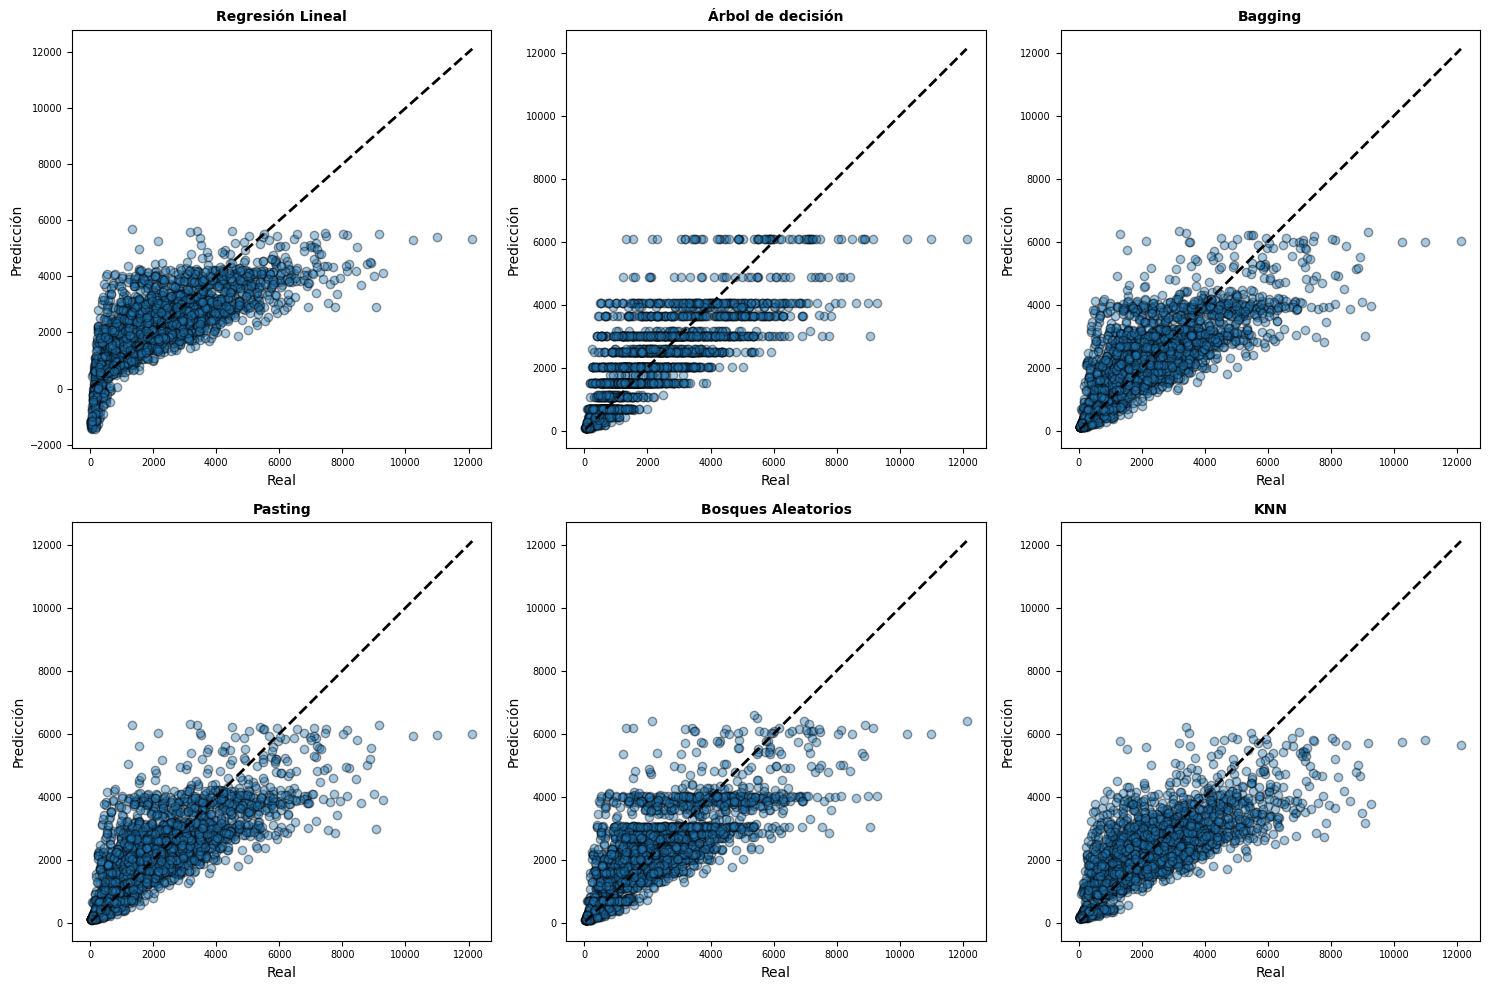

In [117]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

ax1 = plt.subplot(2,3,1)
ax1.scatter(y_test, y_predict_lin_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax1.set_title('Regresión Lineal', fontsize=10, fontweight="bold")
ax1.set_xlabel('Real')
ax1.set_ylabel('Predicción')
ax1.tick_params(labelsize=7)

ax2 = plt.subplot(2,3,2)
ax2.scatter(y_test, y_predict_tree_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax2.set_title('Árbol de decisión', fontsize=10, fontweight="bold")
ax2.set_xlabel('Real')
ax2.set_ylabel('Predicción')
ax2.tick_params(labelsize=7)

ax3 = plt.subplot(2,3,3)
ax3.scatter(y_test, y_predict_bag_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax3.set_title('Bagging', fontsize=10, fontweight="bold")
ax3.set_xlabel('Real')
ax3.set_ylabel('Predicción')
ax3.tick_params(labelsize=7)

ax4 = plt.subplot(2,3,4)
ax4.scatter(y_test, y_predict_pas_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax4.set_title('Pasting', fontsize=10, fontweight="bold")
ax4.set_xlabel('Real')
ax4.set_ylabel('Predicción')
ax4.tick_params(labelsize=7)

ax5 = plt.subplot(2,3,5)
ax5.scatter(y_test, y_predict_rndf_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax5.set_title('Bosques Aleatorios', fontsize=10, fontweight="bold")
ax5.set_xlabel('Real')
ax5.set_ylabel('Predicción')
ax5.tick_params(labelsize=7)

ax6 = plt.subplot(2,3,6)
ax6.scatter(y_test, y_predict_knn_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax6.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax6.set_title('KNN', fontsize=10, fontweight="bold")
ax6.set_xlabel('Real')
ax6.set_ylabel('Predicción')
ax6.tick_params(labelsize=7)

plt.tight_layout()
plt.show()

-El modelo de regresión lineal arroja predicciones de ventas negativas.

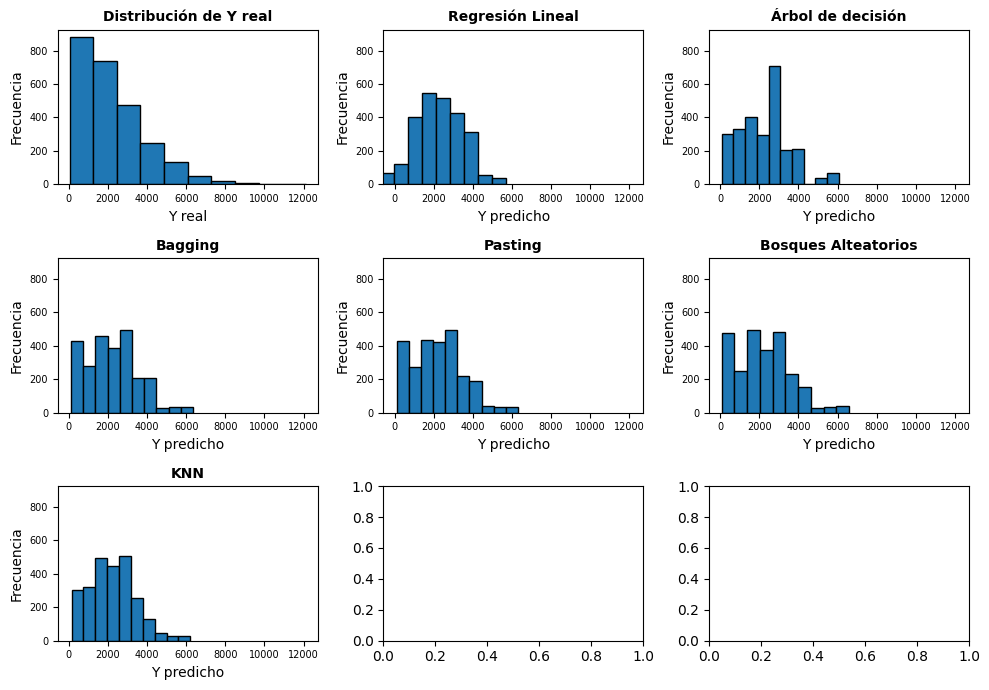

In [118]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 7))

ax1 = plt.subplot(3,3,1)
ax1.hist(y_test, bins=10, edgecolor='black')
ax1.set_title('Distribución de Y real', fontsize=10, fontweight="bold")
ax1.set_xlabel('Y real')
ax1.set_ylabel('Frecuencia')
ax1.tick_params(labelsize=7)
ylim_ax1 = ax1.get_ylim()
xlim_ax1 = ax1.get_xlim()

ax2 = plt.subplot(3,3,2)
ax2.hist(y_predict_lin_reg, bins=10, edgecolor='black')
ax2.set_title('Regresión Lineal', fontsize=10, fontweight="bold")
ax2.set_xlabel('Y predicho')
ax2.set_ylabel('Frecuencia')
ax2.tick_params(labelsize=7)
ax2.set_ylim(ylim_ax1)
ax2.set_xlim(xlim_ax1)

ax3 = plt.subplot(3,3,3)
ax3.hist(y_predict_tree_reg, bins=10, edgecolor='black')
ax3.set_title('Árbol de decisión', fontsize=10, fontweight="bold")
ax3.set_xlabel('Y predicho')
ax3.set_ylabel('Frecuencia')
ax3.tick_params(labelsize=7)
ax3.set_ylim(ylim_ax1)
ax3.set_xlim(xlim_ax1)

ax4 = plt.subplot(3,3,4)
ax4.hist(y_predict_bag_reg, bins=10, edgecolor='black')
ax4.set_title('Bagging', fontsize=10, fontweight="bold")
ax4.set_xlabel('Y predicho')
ax4.set_ylabel('Frecuencia')
ax4.tick_params(labelsize=7)
ax4.set_ylim(ylim_ax1)
ax4.set_xlim(xlim_ax1)

ax5 = plt.subplot(3,3,5)
ax5.hist(y_predict_pas_reg, bins=10, edgecolor='black')
ax5.set_title('Pasting', fontsize=10, fontweight="bold")
ax5.set_xlabel('Y predicho')
ax5.set_ylabel('Frecuencia')
ax5.tick_params(labelsize=7)
ax5.set_ylim(ylim_ax1)
ax5.set_xlim(xlim_ax1)

ax6 = plt.subplot(3,3,6)
ax6.hist(y_predict_rndf_reg, bins=10, edgecolor='black')
ax6.set_title('Bosques Alteatorios', fontsize=10, fontweight="bold")
ax6.set_xlabel('Y predicho')
ax6.set_ylabel('Frecuencia')
ax6.tick_params(labelsize=7)
ax6.set_ylim(ylim_ax1)
ax6.set_xlim(xlim_ax1)

ax7 = plt.subplot(3,3,7)
ax7.hist(y_predict_knn_reg, bins=10, edgecolor='black')
ax7.set_title('KNN', fontsize=10, fontweight="bold")
ax7.set_xlabel('Y predicho')
ax7.set_ylabel('Frecuencia')
ax7.tick_params(labelsize=7)
ax7.set_ylim(ylim_ax1)
ax7.set_xlim(xlim_ax1)

plt.tight_layout()
plt.show()

- En general, todos los modelos tuvieron un mal ajuste y tenían grandes errores.
- Se pueden mejorar reduciendo el número de características al considerar solo las que estén más relacionadas con las ventas.

#MODELO DE REGRESIÓN CON LAS FEATURES QUE TIENEN MAYOR CORRELACIÓN CON TARGET

In [121]:
X_concatenado = pd.concat([X_encoded, y], axis=1)
X_concatenado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   item_mrp                         8519 non-null   float64
 1   item_w                           8519 non-null   float64
 2   item_fat                         8519 non-null   float64
 3   outlet_loc_type                  8519 non-null   float64
 4   item_type_Baking Goods           8519 non-null   float64
 5   item_type_Breads                 8519 non-null   float64
 6   item_type_Breakfast              8519 non-null   float64
 7   item_type_Canned                 8519 non-null   float64
 8   item_type_Dairy                  8519 non-null   float64
 9   item_type_Frozen Foods           8519 non-null   float64
 10  item_type_Fruits and Vegetables  8519 non-null   float64
 11  item_type_Hard Drinks            8519 non-null   float64
 12  item_type_Health and Hygi

<Axes: >

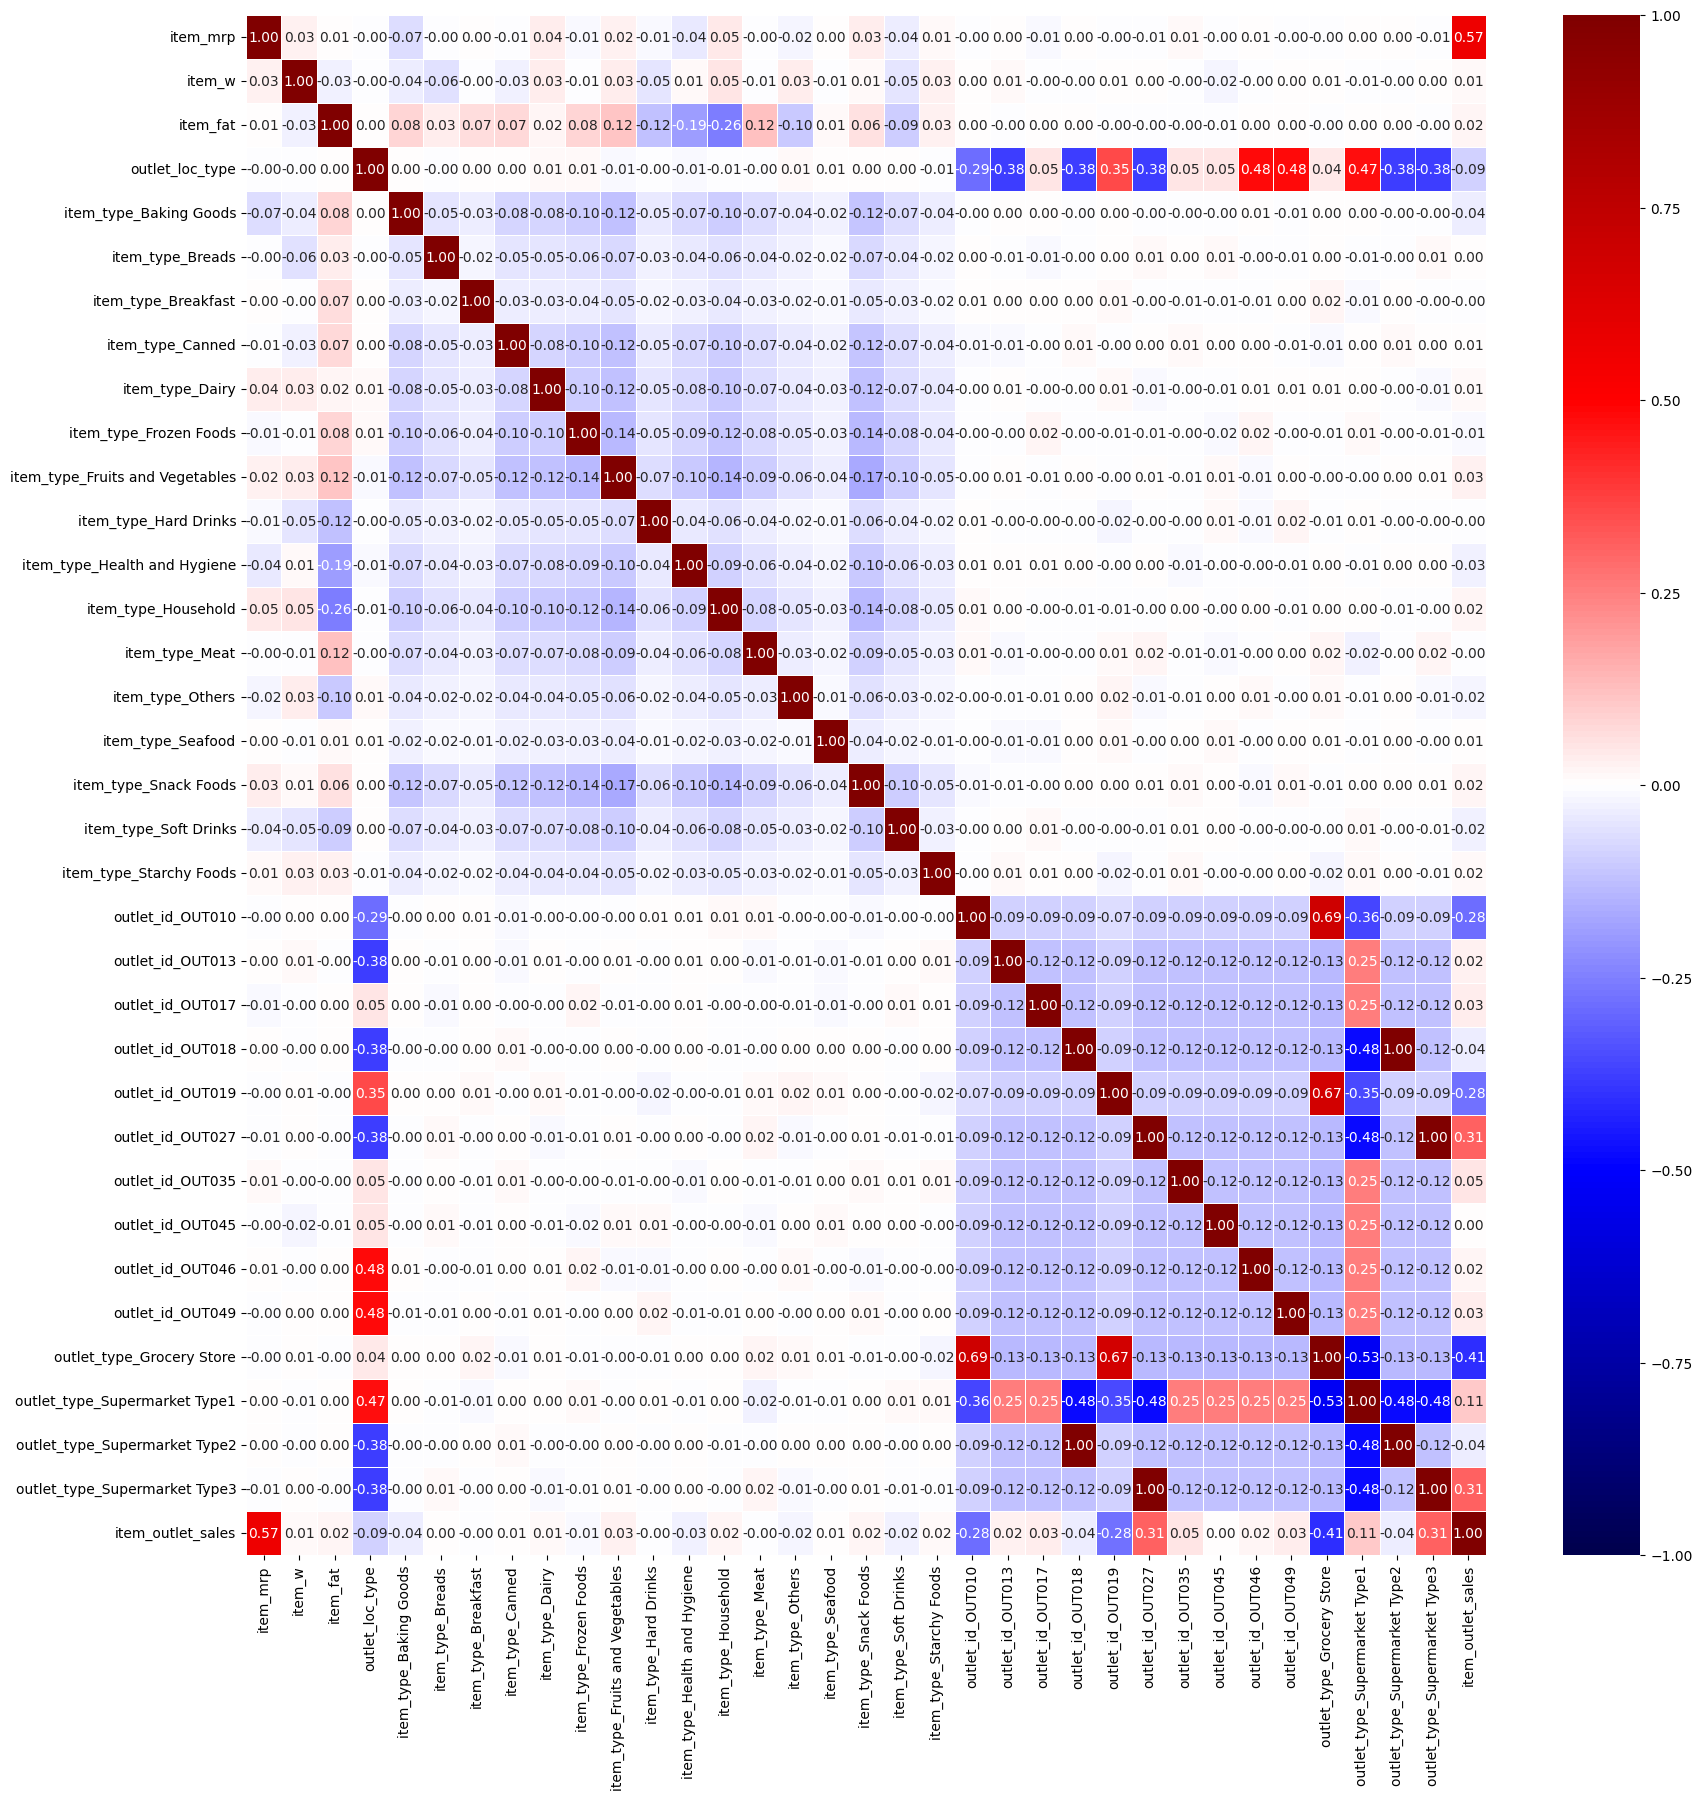

In [126]:
plt.figure(figsize=(20,20))
corr = X_concatenado.corr()
sns.heatmap(corr, annot=True, cmap='seismic', fmt=".2f", linewidth=.5,
            vmin=-1, vmax=1)

Las características que están más relacionadas con las ventas son:
- item_mrp
- outlet_type
- outlet_id
- outlet_loc_type
- item_type

In [127]:
X_encoded.drop(['item_w', 'item_fat'], axis=1, inplace=True)
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   item_mrp                         8519 non-null   float64
 1   outlet_loc_type                  8519 non-null   float64
 2   item_type_Baking Goods           8519 non-null   float64
 3   item_type_Breads                 8519 non-null   float64
 4   item_type_Breakfast              8519 non-null   float64
 5   item_type_Canned                 8519 non-null   float64
 6   item_type_Dairy                  8519 non-null   float64
 7   item_type_Frozen Foods           8519 non-null   float64
 8   item_type_Fruits and Vegetables  8519 non-null   float64
 9   item_type_Hard Drinks            8519 non-null   float64
 10  item_type_Health and Hygiene     8519 non-null   float64
 11  item_type_Household              8519 non-null   float64
 12  item_type_Meat           

###Parámetros del mejor modelo para árbol de decisión

In [128]:
param_grid_tree_reg = [{'max_depth':[1,2,3,4,5,6,7,8,9,10,
                                     11,12,13,14,15,16,17,18,19,20,
                                     21,22,23,24,25,26,27,28,29,30,
                                     31,32]}]

In [129]:
grid_tree_reg = DecisionTreeRegressor()

grid_search_tree_reg = GridSearchCV(grid_tree_reg, param_grid_tree_reg, cv=5,
                           return_train_score=True)

grid_search_tree_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                        23, 24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True)

In [130]:
cvres_tree_reg = grid_search_tree_reg.cv_results_
for values in zip(cvres_tree_reg['mean_test_score'], cvres_tree_reg['params']):
    print(values)

(0.22708559298771513, {'max_depth': 1})
(0.4308531314951127, {'max_depth': 2})
(0.5241530802772036, {'max_depth': 3})
(0.5797503699530181, {'max_depth': 4})
(0.5854915052942923, {'max_depth': 5})
(0.5787590801009708, {'max_depth': 6})
(0.5656576076161157, {'max_depth': 7})
(0.5395989741169849, {'max_depth': 8})
(0.5178917275472841, {'max_depth': 9})
(0.49140095075887447, {'max_depth': 10})
(0.4537178082250721, {'max_depth': 11})
(0.43959109919059786, {'max_depth': 12})
(0.40406053618601756, {'max_depth': 13})
(0.361918890962128, {'max_depth': 14})
(0.3434103383567849, {'max_depth': 15})
(0.3143424747041213, {'max_depth': 16})
(0.2996480527196466, {'max_depth': 17})
(0.27041739085594196, {'max_depth': 18})
(0.2567170646347273, {'max_depth': 19})
(0.24119445054521846, {'max_depth': 20})
(0.22929362292337901, {'max_depth': 21})
(0.21540231831023632, {'max_depth': 22})
(0.20400433161055415, {'max_depth': 23})
(0.20836369783350586, {'max_depth': 24})
(0.20946341584717895, {'max_depth': 25})

El mejor promedio de score se obtiene con max_depth = 5

##Parámetros del mejor modelo para bagging

In [138]:
param_grid_bag_reg = [{'n_estimators':[100, 200, 300, 400, 500],
                       'max_samples':[50, 100, 300, 500]}]

In [139]:
grid_bag_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5),
                                 bootstrap=True)

grid_search_bag_reg = GridSearchCV(grid_bag_reg, param_grid_bag_reg, cv=5,
                                   return_train_score=True)

grid_search_bag_reg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5)),
             param_grid=[{'max_samples': [50, 100, 300, 500],
                          'n_estimators': [100, 200, 300, 400, 500]}],
             return_train_score=True)

In [140]:
cvres_bag_reg = grid_search_bag_reg.cv_results_
for values in zip(cvres_bag_reg['mean_test_score'], cvres_bag_reg['params']):
    print(values)

(0.5569882907176295, {'max_samples': 50, 'n_estimators': 100})
(0.5518547863094582, {'max_samples': 50, 'n_estimators': 200})
(0.5509904308743685, {'max_samples': 50, 'n_estimators': 300})
(0.5524905732504912, {'max_samples': 50, 'n_estimators': 400})
(0.5495271629345277, {'max_samples': 50, 'n_estimators': 500})
(0.5818168260157892, {'max_samples': 100, 'n_estimators': 100})
(0.5863080460933865, {'max_samples': 100, 'n_estimators': 200})
(0.5861063321019753, {'max_samples': 100, 'n_estimators': 300})
(0.5889698690011116, {'max_samples': 100, 'n_estimators': 400})
(0.5867195253702908, {'max_samples': 100, 'n_estimators': 500})
(0.601397620408254, {'max_samples': 300, 'n_estimators': 100})
(0.6008475345933025, {'max_samples': 300, 'n_estimators': 200})
(0.6000571559749331, {'max_samples': 300, 'n_estimators': 300})
(0.6007300840001578, {'max_samples': 300, 'n_estimators': 400})
(0.5996891098066053, {'max_samples': 300, 'n_estimators': 500})
(0.6012482956954299, {'max_samples': 500, 'n_e

n_estimators=500, max_samples=500

##Parámetros del mejor modelo para pasting

In [141]:
param_grid_pas_reg = [{'n_estimators':[100, 200, 300, 400, 500],
                       'max_samples':[50, 100, 300, 500]}]

In [142]:
grid_pas_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5),
                                 bootstrap=False)

grid_search_pas_reg = GridSearchCV(grid_pas_reg, param_grid_pas_reg, cv=5,
                                   return_train_score=True)

grid_search_pas_reg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(bootstrap=False,
                                        estimator=DecisionTreeRegressor(max_depth=5)),
             param_grid=[{'max_samples': [50, 100, 300, 500],
                          'n_estimators': [100, 200, 300, 400, 500]}],
             return_train_score=True)

In [143]:
cvres_pas_reg = grid_search_pas_reg.cv_results_
for values in zip(cvres_pas_reg['mean_test_score'], cvres_pas_reg['params']):
    print(values)

(0.5465867698762912, {'max_samples': 50, 'n_estimators': 100})
(0.5516779432371688, {'max_samples': 50, 'n_estimators': 200})
(0.5536001527619543, {'max_samples': 50, 'n_estimators': 300})
(0.5513195662771, {'max_samples': 50, 'n_estimators': 400})
(0.5515664391861265, {'max_samples': 50, 'n_estimators': 500})
(0.5849949050127103, {'max_samples': 100, 'n_estimators': 100})
(0.586821269098037, {'max_samples': 100, 'n_estimators': 200})
(0.5873333998491554, {'max_samples': 100, 'n_estimators': 300})
(0.5882462270051146, {'max_samples': 100, 'n_estimators': 400})
(0.5882454717161356, {'max_samples': 100, 'n_estimators': 500})
(0.599813017107625, {'max_samples': 300, 'n_estimators': 100})
(0.6007627662501548, {'max_samples': 300, 'n_estimators': 200})
(0.6016557448014104, {'max_samples': 300, 'n_estimators': 300})
(0.6003724863948965, {'max_samples': 300, 'n_estimators': 400})
(0.6011411557153, {'max_samples': 300, 'n_estimators': 500})
(0.6012888911034416, {'max_samples': 500, 'n_estimato

n_estimators=400, max_samples=500

##Parámetros del mejor modelo para bosques aleatorios

In [146]:
param_grid_rndf_reg = [
    {'n_estimators':[100,200,300,400,500]},
    {'n_estimators': [10,20,30,40,50,60,70,80,90,100,200,300], 'max_depth':[1,2,3,4,5,6,7,8,9,10]}]

In [147]:
grid_rndf_reg = RandomForestRegressor()

grid_search_rndf_reg = GridSearchCV(grid_rndf_reg, param_grid_rndf_reg, cv=5,
                                    return_train_score=True)

grid_search_rndf_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'n_estimators': [100, 200, 300, 400, 500]},
                         {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100, 200, 300]}],
             return_train_score=True)

In [148]:
cvres_rndf_reg = grid_search_rndf_reg.cv_results_
for values in zip(cvres_rndf_reg['mean_test_score'], cvres_rndf_reg['params']):
    print(values)

(0.5520964593695117, {'n_estimators': 100})
(0.5527963207300411, {'n_estimators': 200})
(0.5536647000535394, {'n_estimators': 300})
(0.5555641842071604, {'n_estimators': 400})
(0.5547085131490365, {'n_estimators': 500})
(0.24810826777638403, {'max_depth': 1, 'n_estimators': 10})
(0.25122585794742003, {'max_depth': 1, 'n_estimators': 20})
(0.24865204164912053, {'max_depth': 1, 'n_estimators': 30})
(0.24753040655320574, {'max_depth': 1, 'n_estimators': 40})
(0.24961219561805717, {'max_depth': 1, 'n_estimators': 50})
(0.24821062162923954, {'max_depth': 1, 'n_estimators': 60})
(0.2484821469424988, {'max_depth': 1, 'n_estimators': 70})
(0.24843937391330367, {'max_depth': 1, 'n_estimators': 80})
(0.2492864959438928, {'max_depth': 1, 'n_estimators': 90})
(0.2490140041624941, {'max_depth': 1, 'n_estimators': 100})
(0.24870993730120836, {'max_depth': 1, 'n_estimators': 200})
(0.2489888713308332, {'max_depth': 1, 'n_estimators': 300})
(0.4647775546933744, {'max_depth': 2, 'n_estimators': 10})
(0

El mejor promedio de score se obtiene con max_depth=5, n_estimators=60

##Parámetros del mejor modelo para KNN

In [149]:
param_grid_knn_reg = [{'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,41,42,43,44,45,46,47,48,49,50,60,70,100]}]

In [150]:
grid_knn_reg = KNeighborsRegressor()

grid_search_knn_reg = GridSearchCV(grid_knn_reg, param_grid_knn_reg, cv=5,
                                    return_train_score=True)

grid_search_knn_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 25,
                                          30, 35, 40, 41, 42, 43, 44, 45, 46,
                                          47, ...]}],
             return_train_score=True)

In [151]:
cvres_knn_reg = grid_search_knn_reg.cv_results_
for values in zip(cvres_knn_reg['mean_test_score'], cvres_knn_reg['params']):
    print(values)

(0.41089558375948665, {'n_neighbors': 2})
(0.4656353575229663, {'n_neighbors': 3})
(0.4970605972241466, {'n_neighbors': 4})
(0.5127514921994777, {'n_neighbors': 5})
(0.5245899595880011, {'n_neighbors': 6})
(0.5278095431744727, {'n_neighbors': 7})
(0.5320977023843673, {'n_neighbors': 8})
(0.5385874376493656, {'n_neighbors': 9})
(0.5468390774783454, {'n_neighbors': 10})
(0.5500978186472327, {'n_neighbors': 11})
(0.5546736409725125, {'n_neighbors': 12})
(0.5586283251527633, {'n_neighbors': 13})
(0.5608588891700306, {'n_neighbors': 14})
(0.5618076491224613, {'n_neighbors': 15})
(0.5638664778966492, {'n_neighbors': 16})
(0.5663620619051069, {'n_neighbors': 17})
(0.5691860082542413, {'n_neighbors': 18})
(0.5711129399724406, {'n_neighbors': 19})
(0.5727408172168692, {'n_neighbors': 20})
(0.5762048276539866, {'n_neighbors': 25})
(0.5796104071438439, {'n_neighbors': 30})
(0.5818157494955953, {'n_neighbors': 35})
(0.5825889532446885, {'n_neighbors': 40})
(0.5824579329349607, {'n_neighbors': 41})

El mejor promedio de score se obtiene con n_neighbors=50.

##Entrenamiento

In [152]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(max_depth=5, random_state = 77)
bag_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=500, max_samples=500,
                                 bootstrap=True)
pas_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=400, max_samples=500,
                                 bootstrap=False)
rndf_reg = RandomForestRegressor(max_depth=5, n_estimators=60, random_state=77)
knn_reg = KNeighborsRegressor(n_neighbors=50)

In [153]:
lin_reg.fit(X_train, y_train)
tree_reg.fit(X_train, y_train)
bag_reg.fit(X_train, y_train)
pas_reg.fit(X_train, y_train)
rndf_reg.fit(X_train, y_train)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=50)

##Predicción del target (y)

In [154]:
y_predict_lin_reg = lin_reg.predict(X_test)
y_predict_tree_reg = tree_reg.predict(X_test)
y_predict_bag_reg = bag_reg.predict(X_test)
y_predict_pas_reg = pas_reg.predict(X_test)
y_predict_rndf_reg = rndf_reg.predict(X_test)
y_predict_knn_reg = knn_reg.predict(X_test)

##Evaluación de los modelos

In [155]:
r2_lin_reg_train = lin_reg.score(X_train, y_train).round(2)
r2_tree_reg_train = tree_reg.score(X_train, y_train).round(2)
r2_bag_reg_train = bag_reg.score(X_train, y_train).round(2)
r2_pas_reg_train = pas_reg.score(X_train, y_train).round(2)
r2_rndf_reg_train = rndf_reg.score(X_train, y_train).round(2)
r2_knn_reg_train = knn_reg.score(X_train, y_train).round(2)

In [156]:
r2_lin_reg_test = lin_reg.score(X_test, y_test).round(2)
r2_tree_reg_test = tree_reg.score(X_test, y_test).round(2)
r2_bag_reg_test = bag_reg.score(X_test, y_test).round(2)
r2_pas_reg_test = pas_reg.score(X_test, y_test).round(2)
r2_rndf_reg_test = rndf_reg.score(X_test, y_test).round(2)
r2_knn_reg_test = knn_reg.score(X_test, y_test).round(2)

In [157]:
mae_lin_reg = mean_absolute_error(y_test, y_predict_lin_reg).round(2)
mae_tree_reg = mean_absolute_error(y_test, y_predict_tree_reg).round(2)
mae_bag_reg = mean_absolute_error(y_test, y_predict_bag_reg).round(2)
mae_pas_reg = mean_absolute_error(y_test, y_predict_pas_reg).round(2)
mae_rndf_reg = mean_absolute_error(y_test, y_predict_rndf_reg).round(2)
mae_knn_reg = mean_absolute_error(y_test, y_predict_knn_reg).round(2)

In [158]:
mse_lin_reg = mean_squared_error(y_test, y_predict_lin_reg).round(2)
mse_tree_reg = mean_squared_error(y_test, y_predict_tree_reg).round(2)
mse_bag_reg = mean_squared_error(y_test, y_predict_bag_reg).round(2)
mse_pas_reg = mean_squared_error(y_test, y_predict_pas_reg).round(2)
mse_rndf_reg = mean_squared_error(y_test, y_predict_rndf_reg).round(2)
mse_knn_reg = mean_squared_error(y_test, y_predict_knn_reg).round(2)

In [159]:
rmse_lin_reg = mean_squared_error(y_test, y_predict_lin_reg, squared=False).round(2)
rmse_tree_reg = mean_squared_error(y_test, y_predict_tree_reg, squared=False).round(2)
rmse_bag_reg = mean_squared_error(y_test, y_predict_bag_reg, squared=False).round(2)
rmse_pas_reg = mean_squared_error(y_test, y_predict_pas_reg, squared=False).round(2)
rmse_rndf_reg = mean_squared_error(y_test, y_predict_rndf_reg, squared=False).round(2)
rmse_knn_reg = mean_squared_error(y_test, y_predict_knn_reg, squared=False).round(2)

In [163]:
modelos = ['Regresión Lineal', 'Árbol de Decisión', 'Bagging', 'Pasting', 'Bosques Aleatorios', 'KNN']
r2_reg_train = [r2_lin_reg_train,
                r2_tree_reg_train,
                r2_bag_reg_train,
                r2_pas_reg_train,
                r2_rndf_reg_train,
                r2_knn_reg_train]
r2_reg_test = [r2_lin_reg_test,
               r2_tree_reg_test,
               r2_bag_reg_test,
               r2_pas_reg_test,
               r2_rndf_reg_test,
               r2_knn_reg_test]
sobreajuste = [abs(r2_lin_reg_train-r2_lin_reg_test),
               abs(r2_tree_reg_train-r2_tree_reg_test),
               abs(r2_bag_reg_train-r2_bag_reg_test),
               abs(r2_pas_reg_train-r2_pas_reg_test),
               abs(r2_rndf_reg_train-r2_rndf_reg_test),
               abs(r2_knn_reg_train-r2_knn_reg_test)]
mae_reg = [mae_lin_reg,
           mae_tree_reg,
           mae_bag_reg,
           mae_pas_reg,
           mae_rndf_reg,
           mae_knn_reg]
mse_reg = [mse_lin_reg,
           mse_tree_reg,
           mse_bag_reg,
           mse_pas_reg,
           mse_rndf_reg,
           mse_knn_reg]
rmse_reg = [rmse_lin_reg,
            rmse_tree_reg,
            rmse_bag_reg,
            rmse_pas_reg,
            rmse_rndf_reg,
            rmse_knn_reg]

metricas_reg = pd.DataFrame({
    'Modelos': modelos,
    'R2 train': r2_reg_train,
    'R2 test': r2_reg_test,
    'Sobreajuste': sobreajuste,
    'MAE': mae_reg,
    'MSE': mse_reg,
    'RMSE': rmse_reg})

metricas_reg = metricas_reg.set_index('Modelos')
metricas_reg.index.name = 'Métricas'
metricas_reg = metricas_reg.T
metricas_reg

Métricas,Regresión Lineal,Árbol de Decisión,Bagging,Pasting,Bosques Aleatorios,KNN
R2 train,0.57,0.61,0.61,0.62,0.62,0.60
R2 test,0.55,0.59,0.59,0.59,0.59,0.58
Sobreajuste,0.02,0.02,0.02,0.03,0.03,0.02
MAE,851.07,779.50,775.86,774.57,773.72,799.91
MSE,1331397.23,1235146.95,1222301.42,1220195.54,1217162.66,1266642.49
RMSE,1153.86,1111.37,1105.58,1104.62,1103.25,1125.45


- Los modelos no están sobreajustados, pero tienen granden errores (MSE muy altos), y tienen un bajo R2.

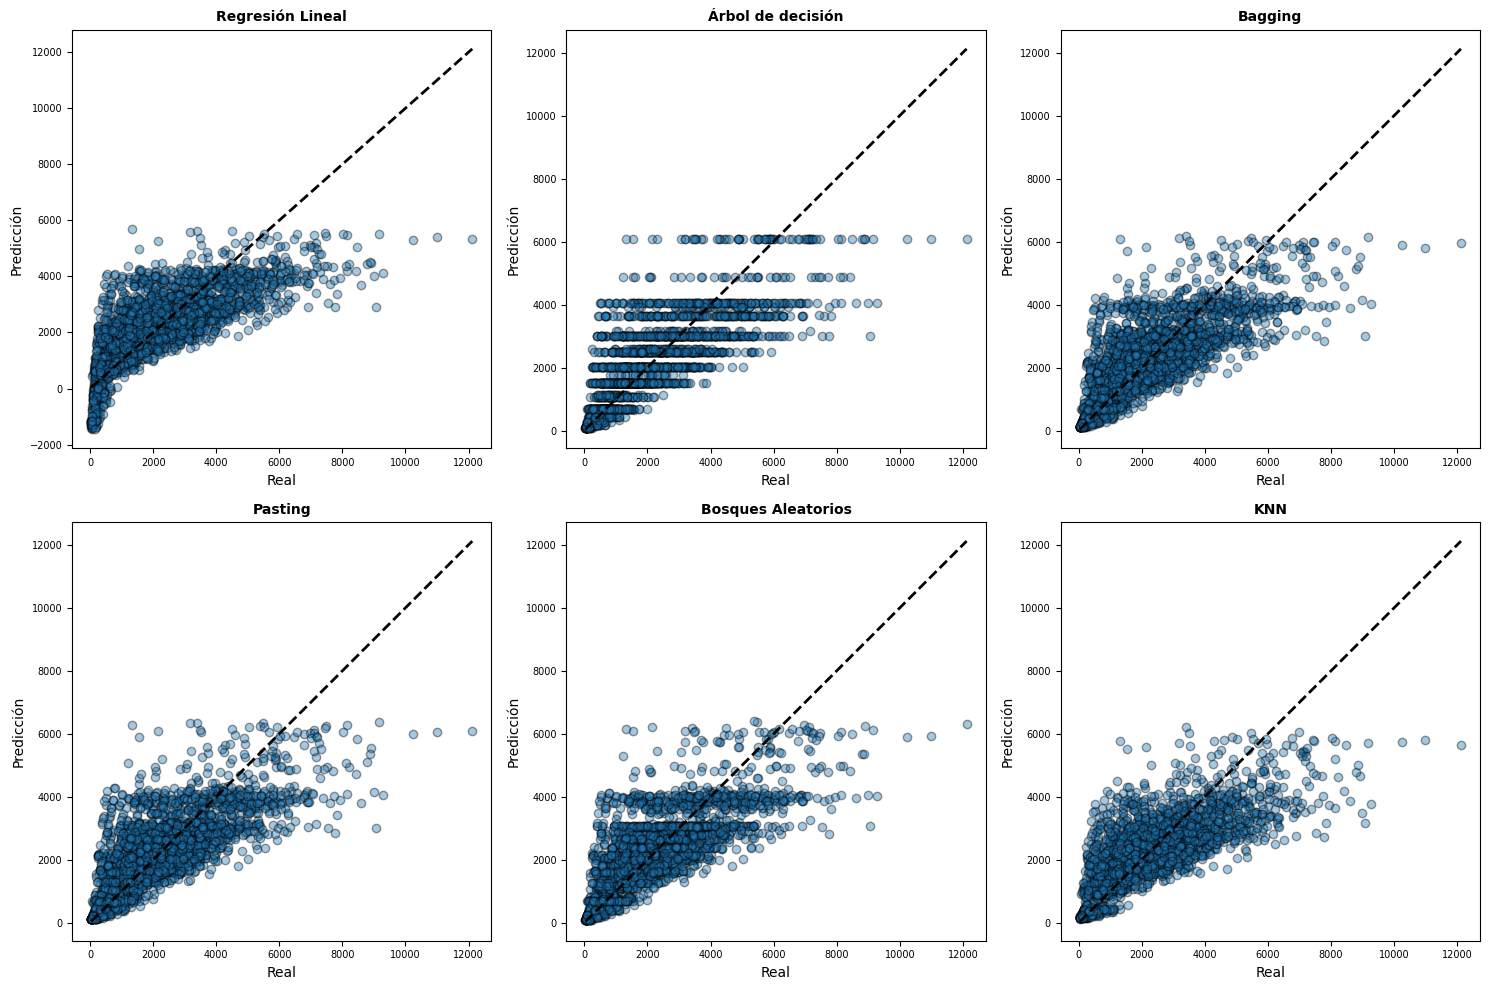

In [161]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

ax1 = plt.subplot(2,3,1)
ax1.scatter(y_test, y_predict_lin_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax1.set_title('Regresión Lineal', fontsize=10, fontweight="bold")
ax1.set_xlabel('Real')
ax1.set_ylabel('Predicción')
ax1.tick_params(labelsize=7)

ax2 = plt.subplot(2,3,2)
ax2.scatter(y_test, y_predict_tree_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax2.set_title('Árbol de decisión', fontsize=10, fontweight="bold")
ax2.set_xlabel('Real')
ax2.set_ylabel('Predicción')
ax2.tick_params(labelsize=7)

ax3 = plt.subplot(2,3,3)
ax3.scatter(y_test, y_predict_bag_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax3.set_title('Bagging', fontsize=10, fontweight="bold")
ax3.set_xlabel('Real')
ax3.set_ylabel('Predicción')
ax3.tick_params(labelsize=7)

ax4 = plt.subplot(2,3,4)
ax4.scatter(y_test, y_predict_pas_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax4.set_title('Pasting', fontsize=10, fontweight="bold")
ax4.set_xlabel('Real')
ax4.set_ylabel('Predicción')
ax4.tick_params(labelsize=7)

ax5 = plt.subplot(2,3,5)
ax5.scatter(y_test, y_predict_rndf_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax5.set_title('Bosques Aleatorios', fontsize=10, fontweight="bold")
ax5.set_xlabel('Real')
ax5.set_ylabel('Predicción')
ax5.tick_params(labelsize=7)

ax6 = plt.subplot(2,3,6)
ax6.scatter(y_test, y_predict_knn_reg, edgecolors=(0, 0, 0), alpha=0.4)
ax6.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax6.set_title('KNN', fontsize=10, fontweight="bold")
ax6.set_xlabel('Real')
ax6.set_ylabel('Predicción')
ax6.tick_params(labelsize=7)

plt.tight_layout()
plt.show()

-El modelo de regresión lineal arroja predicciones de ventas negativas.

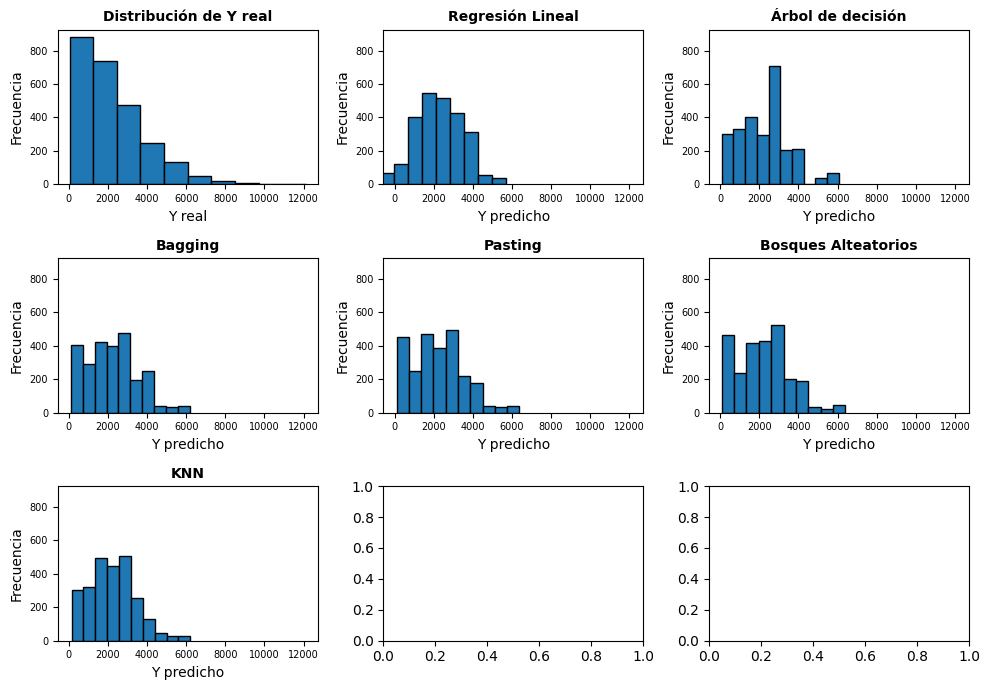

In [162]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 7))

ax1 = plt.subplot(3,3,1)
ax1.hist(y_test, bins=10, edgecolor='black')
ax1.set_title('Distribución de Y real', fontsize=10, fontweight="bold")
ax1.set_xlabel('Y real')
ax1.set_ylabel('Frecuencia')
ax1.tick_params(labelsize=7)
ylim_ax1 = ax1.get_ylim()
xlim_ax1 = ax1.get_xlim()

ax2 = plt.subplot(3,3,2)
ax2.hist(y_predict_lin_reg, bins=10, edgecolor='black')
ax2.set_title('Regresión Lineal', fontsize=10, fontweight="bold")
ax2.set_xlabel('Y predicho')
ax2.set_ylabel('Frecuencia')
ax2.tick_params(labelsize=7)
ax2.set_ylim(ylim_ax1)
ax2.set_xlim(xlim_ax1)

ax3 = plt.subplot(3,3,3)
ax3.hist(y_predict_tree_reg, bins=10, edgecolor='black')
ax3.set_title('Árbol de decisión', fontsize=10, fontweight="bold")
ax3.set_xlabel('Y predicho')
ax3.set_ylabel('Frecuencia')
ax3.tick_params(labelsize=7)
ax3.set_ylim(ylim_ax1)
ax3.set_xlim(xlim_ax1)

ax4 = plt.subplot(3,3,4)
ax4.hist(y_predict_bag_reg, bins=10, edgecolor='black')
ax4.set_title('Bagging', fontsize=10, fontweight="bold")
ax4.set_xlabel('Y predicho')
ax4.set_ylabel('Frecuencia')
ax4.tick_params(labelsize=7)
ax4.set_ylim(ylim_ax1)
ax4.set_xlim(xlim_ax1)

ax5 = plt.subplot(3,3,5)
ax5.hist(y_predict_pas_reg, bins=10, edgecolor='black')
ax5.set_title('Pasting', fontsize=10, fontweight="bold")
ax5.set_xlabel('Y predicho')
ax5.set_ylabel('Frecuencia')
ax5.tick_params(labelsize=7)
ax5.set_ylim(ylim_ax1)
ax5.set_xlim(xlim_ax1)

ax6 = plt.subplot(3,3,6)
ax6.hist(y_predict_rndf_reg, bins=10, edgecolor='black')
ax6.set_title('Bosques Alteatorios', fontsize=10, fontweight="bold")
ax6.set_xlabel('Y predicho')
ax6.set_ylabel('Frecuencia')
ax6.tick_params(labelsize=7)
ax6.set_ylim(ylim_ax1)
ax6.set_xlim(xlim_ax1)

ax7 = plt.subplot(3,3,7)
ax7.hist(y_predict_knn_reg, bins=10, edgecolor='black')
ax7.set_title('KNN', fontsize=10, fontweight="bold")
ax7.set_xlabel('Y predicho')
ax7.set_ylabel('Frecuencia')
ax7.tick_params(labelsize=7)
ax7.set_ylim(ylim_ax1)
ax7.set_xlim(xlim_ax1)

plt.tight_layout()
plt.show()

- En general, todos los modelos tuvieron un mal ajuste y tenían grandes errores.
- Se pueden mejorar reduciendo el número de características al considerar solo las que estén más relacionadas con las ventas.